# Team: Innovator

# Problem Statement:
### **CAI-Powered User & Entity Behaviour Analytics (UEBA) for Fraud Detection**





# UEBA-Style Synthetic Transaction Generator

This below cell generates **synthetic financial transactions** for UEBA (User and Entity Behavior Analytics) use cases.  
It simulates **users, accounts, merchants, devices, IPs, and transactions** — including both **legitimate behavior** and **fraudulent patterns**.

Since no real dataset was provided, we generated a synthetic dataset through simulation to build the complete prototype. However, the generated data may be imbalanced, which could impact accuracy and precision during training and lead to biased evaluation results. This imbalance may affect testing performance, but in real-world scenarios with user-specific data, the system is expected to work effectively.

---

## Features

- **User Simulation**
  - Metadata: age, region, signup date, risk score.
  - Each user gets at least one checking account.
  - Assigned devices (mobile, desktop, tablet) and IP addresses.

- **Merchants**
  - Categories: retail, utilities, salary, food, travel.
  - Special salary merchants for recurring monthly credits.

- **Transactions**
  - Realistic behaviors:  
    - Salary deposits (monthly).  
    - Recurring bills (utilities, rent).  
    - Merchant purchases.  
    - Peer-to-peer transfers.  

- **Fraudulent Patterns Injected**
  - **Account Takeover (ATO)** → device/IP mismatch, rapid high-value transfers.  
  - **Rapid micro-transfers (bot style)** → many small transfers in a burst.  
  - **Round-tripping / Wash trades** → quick send-and-return transfers.  
  - **Credential stuffing-like test transactions** → many low-value rapid transfers.  


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from faker import Faker
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")
fake = Faker()
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
Faker.seed(RANDOM_SEED)

def simulate_ueba_dataset(
    num_users=500,
    num_merchants=80,
    avg_transactions_per_user=20,
    period_days=90,
    fraud_user_frac=0.05
):
    """
    Returns (users_df, accounts_df, merchants_df, transactions_df)
    - users_df: user metadata (age, region, risk_score)
    - accounts_df: account metadata (account_id, user_id, type, created_date)
    - merchants_df: merchant list
    - transactions_df: time-sorted transactions with channels, device, ip, is_fraud
    """
    print("Starting UEBA-style data simulation...")
    regions = ['North', 'South', 'East', 'West', 'Central']
    channels = ['internet', 'mobile_app', 'UPI', 'ATM', 'API']

    users = []
    accounts = []
    devices = []
    ips = []

    for i in range(num_users):
        user_id = f'user_{i}'
        signup_date = fake.date_time_between(start_date='-2y', end_date='-30d')
        age = int(np.clip(np.random.normal(35, 10), 18, 80))
        region = random.choice(regions)
        risk_score = float(np.clip(np.random.beta(2, 8), 0, 1))

        users.append({
            'user_id': user_id,
            'name': fake.name(),
            'signup_date': signup_date,
            'age': age,
            'region': region,
            'risk_score': round(risk_score, 3)
        })
        created_date = signup_date + timedelta(days=random.randint(1, 30))
        accounts.append({
            'account_id': f'acc_{i}',
            'user_id': user_id,
            'account_type': 'checking',
            'created_date': created_date
        })
        num_devices = 1 if random.random() < 0.7 else 2
        for d in range(num_devices):
            devices.append({
                'device_id': f'dev_{i}_{d}',
                'user_id': user_id,
                'device_type': random.choice(['mobile', 'desktop', 'tablet'])
            })

        for _ in range(random.randint(1, 3)):
            ips.append({
                'ip_address': fake.ipv4(),
                'user_id': user_id
            })

    merchants = [{'merchant_id': f'merch_{i}', 'name': fake.company(), 'category': random.choice(['retail','utilities','salary','food','travel'])}
                 for i in range(num_merchants)]

    users_df = pd.DataFrame(users)
    accounts_df = pd.DataFrame(accounts)
    devices_df = pd.DataFrame(devices)
    ips_df = pd.DataFrame(ips)
    merchants_df = pd.DataFrame(merchants)



    salary_merchants = merchants_df[merchants_df['category'] == 'salary']
    if salary_merchants.empty:

        salary_merchants = pd.DataFrame([{'merchant_id':'merch_salary_0','name':'Acme Corp','category':'salary'}])


    recurring_payees = {}
    for uid in users_df['user_id']:

        if random.random() < 0.3:
            payee = random.choice(merchants_df['merchant_id'].tolist())

            dom = random.randint(1, 28)
            recurring_payees[uid] = {'payee': payee, 'dom': dom, 'amount': round(random.uniform(50, 500),2)}


    transactions = []
    tx_counter = 0
    start_date = datetime.now() - timedelta(days=period_days)
    end_date = datetime.now()

    for i in tqdm(range(num_users), desc="Simulating user transactions"):
        uid = f'user_{i}'
        acc = f'acc_{i}'


        base_mean = avg_transactions_per_user * (1 + users_df.loc[users_df['user_id']==uid, 'risk_score'].values[0])
        num_tx = max(1, int(np.random.normal(base_mean, 5)))


        has_salary = random.random() < 0.6
        salary_merchant = salary_merchants.sample(1).iloc[0]['merchant_id'] if has_salary else None
        if has_salary:

            cur = start_date
            while cur <= end_date:
                pay_dt = cur + timedelta(days=random.randint(25,28))
                if pay_dt <= end_date:
                    transactions.append({
                        'transaction_id': f'tx_{tx_counter}',
                        'from_account': salary_merchant,
                        'to_account': acc,
                        'amount': round(random.uniform(1000, 5000),2),
                        'timestamp': pay_dt,
                        'channel': 'bank_credit',
                        'device_id': None,
                        'ip_address': None,
                        'is_incoming': 1,
                        'is_fraud': 0
                    })
                    tx_counter += 1
                cur = cur + timedelta(days=30)

        for _ in range(num_tx):
            tx_time = start_date + timedelta(seconds=random.randint(0, int((end_date-start_date).total_seconds())))

            r = random.random()
            if r < 0.6:
                to_acc = f'acc_{random.choice([j for j in range(num_users) if j!=i])}'
                is_incoming = 0
            else:

                m = merchants_df.sample(1).iloc[0]['merchant_id']
                to_acc = m
                is_incoming = 0

            dev_pool = devices_df[devices_df['user_id']==uid]['device_id'].tolist()
            ip_pool = ips_df[ips_df['user_id']==uid]['ip_address'].tolist()
            device_id = random.choice(dev_pool) if dev_pool else None
            ip_addr = random.choice(ip_pool) if ip_pool else None

            transactions.append({
                'transaction_id': f'tx_{tx_counter}',
                'from_account': acc,
                'to_account': to_acc,
                'amount': round(random.uniform(5, 800),2),
                'timestamp': tx_time,
                'channel': random.choice(channels),
                'device_id': device_id,
                'ip_address': ip_addr,
                'is_incoming': is_incoming,
                'is_fraud': 0
            })
            tx_counter += 1

        if uid in recurring_payees:
            pay = recurring_payees[uid]

            cur = start_date
            while cur <= end_date:
                pay_dt = cur.replace(day=pay['dom']) if cur.day != pay['dom'] else cur
                try:
                    if pay_dt <= end_date:

                        pay_time = datetime(pay_dt.year, pay_dt.month, pay_dt.day, random.randint(7, 11), random.randint(0,59))
                        transactions.append({
                            'transaction_id': f'tx_{tx_counter}',
                            'from_account': acc,
                            'to_account': pay['payee'],
                            'amount': pay['amount'],
                            'timestamp': pay_time,
                            'channel': random.choice(['internet','mobile_app','UPI']),
                            'device_id': random.choice(dev_pool) if dev_pool else None,
                            'ip_address': random.choice(ip_pool) if ip_pool else None,
                            'is_incoming': 0,
                            'is_fraud': 0
                        })
                        tx_counter += 1
                except Exception:
                    pass

                cur = cur + timedelta(days=30)


    transactions_by_time = transactions[:]
    num_fraud_users = max(1, int(num_users * fraud_user_frac))
    fraud_user_indices = random.sample(range(num_users), num_fraud_users)
    for idx in fraud_user_indices[:int(len(fraud_user_indices)*0.5)]:
        victim_acc = f'acc_{idx}'
        fraud_device = f'dev_fraud_{idx}'
        fraud_ip = fake.ipv4()
        ato_time = datetime.now() - timedelta(days=random.randint(0, 10), hours=random.randint(0,23))
        for k in range(random.randint(2,6)):
            amount = round(random.uniform(800, 5000), 2)
            transactions_by_time.append({
                'transaction_id': f'tx_{tx_counter}',
                'from_account': victim_acc,
                'to_account': f'mule_{idx}_{k}_1',
                'amount': amount,
                'timestamp': ato_time + timedelta(minutes=k*3),
                'channel': random.choice(['internet','mobile_app','API']),
                'device_id': fraud_device,
                'ip_address': fraud_ip,
                'is_incoming': 0,
                'is_fraud': 1
            })
            tx_counter += 1
        num_mule_hops = random.randint(2,4)
        for hop in range(1, num_mule_hops+1):
            from_m = f'mule_{idx}_{hop}_1' if hop>1 else f'mule_{idx}_0_1'
            to_m = f'mule_{idx}_{hop+1}_1'
            transactions_by_time.append({
                'transaction_id': f'tx_{tx_counter}',
                'from_account': from_m,
                'to_account': to_m,
                'amount': round(amount * random.uniform(0.7, 0.95),2),
                'timestamp': ato_time + timedelta(minutes=5 + hop*6),
                'channel': 'bank_transfer',
                'device_id': fraud_device,
                'ip_address': fraud_ip,
                'is_incoming': 0,
                'is_fraud': 1
            })
            tx_counter += 1

    for idx in fraud_user_indices[int(len(fraud_user_indices)*0.5):int(len(fraud_user_indices)*0.8)]:
        sender_acc = f'acc_{idx}'
        burst_time = datetime.now() - timedelta(days=random.randint(0, 20))
        num_micro = random.randint(10, 40)
        for j in range(num_micro):
            to_acc = f'acc_{random.randint(0, num_users-1)}'
            if to_acc == sender_acc:
                continue
            transactions_by_time.append({
                'transaction_id': f'tx_{tx_counter}',
                'from_account': sender_acc,
                'to_account': to_acc,
                'amount': round(random.uniform(1.0, 50.0),2),
                'timestamp': burst_time + timedelta(seconds=j*10),
                'channel': random.choice(['UPI','mobile_app']),
                'device_id': f'dev_{idx}_0',
                'ip_address': ips_df[ips_df['user_id']==f'user_{idx}']['ip_address'].iloc[0],
                'is_incoming': 0,
                'is_fraud': 1
            })
            tx_counter += 1

    for _ in range(int(num_users * 0.02)):
        a = random.randint(0, num_users-1)
        b = random.randint(0, num_users-1)
        if a==b: continue
        t0 = datetime.now() - timedelta(days=random.randint(1, 30))
        amt = round(random.uniform(100, 1500),2)
        transactions_by_time.append({
            'transaction_id': f'tx_{tx_counter}', 'from_account': f'acc_{a}', 'to_account': f'acc_{b}',
            'amount': amt, 'timestamp': t0, 'channel': 'internet', 'device_id': f'dev_{a}_0',
            'ip_address': ips_df[ips_df['user_id']==f'user_{a}']['ip_address'].iloc[0], 'is_incoming': 0, 'is_fraud': 1
        }); tx_counter += 1
        transactions_by_time.append({
            'transaction_id': f'tx_{tx_counter}', 'from_account': f'acc_{b}', 'to_account': f'acc_{a}',
            'amount': round(amt * random.uniform(0.9, 1.0),2), 'timestamp': t0 + timedelta(minutes=random.randint(1,60)),
            'channel': 'internet', 'device_id': f'dev_{b}_0',
            'ip_address': ips_df[ips_df['user_id']==f'user_{b}']['ip_address'].iloc[0], 'is_incoming': 0, 'is_fraud': 1
        }); tx_counter += 1


    for idx in fraud_user_indices[int(len(fraud_user_indices)*0.8):]:
        a = idx
        base_time = datetime.now() - timedelta(days=random.randint(0, 15))
        for s in range(random.randint(8, 20)):
            transactions_by_time.append({
                'transaction_id': f'tx_{tx_counter}',
                'from_account': f'acc_{a}',
                'to_account': f'acc_{random.randint(0, num_users-1)}',
                'amount': round(random.uniform(0.5, 10.0),2),
                'timestamp': base_time + timedelta(seconds=s*5),
                'channel': random.choice(['API','mobile_app']),
                'device_id': f'dev_{a}_0',
                'ip_address': fake.ipv4(),
                'is_incoming': 0,
                'is_fraud': 1
            })
            tx_counter += 1


    transactions_df = pd.DataFrame(transactions_by_time)

    transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'])
    transactions_df = transactions_df.sort_values('timestamp').reset_index(drop=True)

    transactions_df['channel'] = transactions_df['channel'].fillna('bank_credit')

    transactions_df['device_id'] = transactions_df['device_id'].fillna('unknown_device')
    transactions_df['ip_address'] = transactions_df['ip_address'].fillna('0.0.0.0')
    transactions_df['is_fraud'] = transactions_df['is_fraud'].fillna(0).astype(int)
    transactions_df['is_incoming'] = transactions_df['is_incoming'].fillna(0).astype(int)

    transactions_df = transactions_df[~((transactions_df['from_account'] == transactions_df['to_account']) & (transactions_df['from_account'].str.startswith('acc_')))]

    print("Simulation complete.")
    print(f"Total transactions: {len(transactions_df)}; Fraudulent flagged: {transactions_df['is_fraud'].sum()} ({transactions_df['is_fraud'].mean()*100:.2f}%)")

    return users_df, accounts_df, merchants_df, transactions_df

def engineer_basic_features(transactions_df, accounts_df):
    """
    Adds useful behavioral features:
    - account_age_days
    - tx_hour, tx_day_of_week
    - is_new_beneficiary (per from_account)
    - last_tx_interval_seconds
    - rolling windows by count for last 5 txs: mean, sum, count
    """
    print("Starting basic feature engineering...")
    df = transactions_df.copy()

    df = df.merge(accounts_df[['account_id','created_date']], left_on='from_account', right_on='account_id', how='left')
    df.rename(columns={'created_date':'from_account_created_date'}, inplace=True)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)

    df['from_account_created_date'] = pd.to_datetime(df['from_account_created_date'])
    df['account_age_days'] = (df['timestamp'] - df['from_account_created_date']).dt.days.fillna(0).astype(int)

    df['tx_hour'] = df['timestamp'].dt.hour
    df['tx_dayofweek'] = df['timestamp'].dt.dayofweek

    df['is_new_beneficiary'] = df.groupby('from_account')['to_account'].transform(lambda s: (~s.duplicated(keep='first')).astype(int))

    df['prev_timestamp'] = df.groupby('from_account')['timestamp'].shift(1)
    df['last_tx_interval_seconds'] = (df['timestamp'] - df['prev_timestamp']).dt.total_seconds().fillna(-1)

    df['rolling_tx_count_5'] = df.groupby('from_account')['amount'].transform(lambda x: x.rolling(5, min_periods=1).count())
    df['rolling_tx_sum_5'] = df.groupby('from_account')['amount'].transform(lambda x: x.rolling(5, min_periods=1).sum())
    df['rolling_tx_mean_5'] = df.groupby('from_account')['amount'].transform(lambda x: x.rolling(5, min_periods=1).mean())

    now = df['timestamp'].max()
    one_day_ago = now - timedelta(days=1)
    recent = df[df['timestamp'] >= one_day_ago]
    recent_counts = recent.groupby('from_account').size().rename('tx_count_last_1d')
    df = df.merge(recent_counts, left_on='from_account', right_index=True, how='left')
    df['tx_count_last_1d'] = df['tx_count_last_1d'].fillna(0).astype(int)

    df = df.fillna(0)
    print("Feature engineering complete.")
    return df

if __name__ == "__main__":
    users_df, accounts_df, merchants_df, transactions_df = simulate_ueba_dataset(
        num_users=500,
        num_merchants=80,
        avg_transactions_per_user=20,
        period_days=90,
        fraud_user_frac=0.06
    )

    featured = engineer_basic_features(transactions_df, accounts_df)

    featured.to_csv('ueba_transactions_featured.csv', index=False)
    users_df.to_csv('ueba_users.csv', index=False)
    accounts_df.to_csv('ueba_accounts.csv', index=False)
    merchants_df.to_csv('ueba_merchants.csv', index=False)

    print("\nSaved files:")
    print(" - ueba_transactions_featured.csv")
    print(" - ueba_users.csv")
    print(" - ueba_accounts.csv")
    print(" - ueba_merchants.csv")
    print("\nPreview (transactions):")
    print(featured.head().to_string())


Starting UEBA-style data simulation...


Simulating user transactions: 100%|██████████| 500/500 [00:13<00:00, 38.24it/s]


Simulation complete.
Total transactions: 13769; Fraudulent flagged: 396 (2.88%)
Starting basic feature engineering...
Feature engineering complete.

Saved files:
 - ueba_transactions_featured.csv
 - ueba_users.csv
 - ueba_accounts.csv
 - ueba_merchants.csv

Preview (transactions):
  transaction_id from_account to_account  amount           timestamp     channel  device_id       ip_address  is_incoming  is_fraud account_id   from_account_created_date  account_age_days  tx_hour  tx_dayofweek  is_new_beneficiary prev_timestamp  last_tx_interval_seconds  rolling_tx_count_5  rolling_tx_sum_5  rolling_tx_mean_5  tx_count_last_1d
0       tx_11246      acc_422   merch_58  216.01 2025-06-01 07:49:00    internet  dev_422_0  178.102.203.129            0         0    acc_422  2023-10-12 04:33:11.531895               598        7             6                   1              0                      -1.0                 1.0            216.01             216.01                 0
1        tx_2078      

This cell displays the generated merchants dataset, which contains the features: merchant_id, name, and category.

In [ ]:
merchants_df = pd.read_csv('/content/ueba_merchants.csv')
display(merchants_df.head())

,merchant_id,name,category
0,merch_0,"Cooper, Thornton and Fitzgerald",utilities
1,merch_1,"Wilson, Hall and Logan",travel
2,merch_2,Garcia PLC,retail
3,merch_3,Hartman-Owen,retail
4,merch_4,"Terry, Mann and Martin",food


This cell displays the generated transactions_featured dataset, which contains the features: transaction_id, from_account, to_account, amount, timestamp, channel, device_id, ip_address, is_incoming, is_fraud(target variable), and multiple features related to transactions

In [ ]:
transactions_df = pd.read_csv('/content/ueba_transactions_featured.csv')
display(transactions_df.head())

,transaction_id,from_account,to_account,amount,timestamp,channel,device_id,ip_address,is_incoming,is_fraud,...,account_age_days,tx_hour,tx_dayofweek,is_new_beneficiary,prev_timestamp,last_tx_interval_seconds,rolling_tx_count_5,rolling_tx_sum_5,rolling_tx_mean_5,tx_count_last_1d
0,tx_11246,acc_422,merch_58,216.01,2025-06-01 07:49:00.000000,internet,dev_422_0,178.102.203.129,0,0,...,598,7,6,1,0,-1.0,1.0,216.01,216.01,0
1,tx_2078,acc_77,merch_36,276.00,2025-06-01 08:27:00.000000,UPI,dev_77_0,64.200.244.208,0,0,...,-100,8,6,1,0,-1.0,1.0,276.00,276.00,0
2,tx_12389,acc_464,merch_22,478.44,2025-06-01 09:26:00.000000,mobile_app,dev_464_0,108.7.208.175,0,0,...,588,9,6,1,0,-1.0,1.0,478.44,478.44,0
3,tx_10831,acc_406,merch_65,69.82,2025-06-01 10:00:00.000000,internet,dev_406_0,98.175.96.18,0,0,...,517,10,6,1,0,-1.0,1.0,69.82,69.82,15
4,tx_2763,acc_103,merch_40,482.66,2025-06-01 10:23:00.000000,UPI,dev_103_1,201.243.168.129,0,0,...,159,10,6,1,0,-1.0,1.0,482.66,482.66,1


This cell displays the generated users dataset, which contains the features: user_id, name, signup_date, age, region, and risk_score.

In [ ]:
users_df = pd.read_csv('/content/ueba_users.csv')
display(users_df.head())

,user_id,name,signup_date,age,region,risk_score
0,user_0,Donald Walker,2024-12-19 03:57:10.078918,39,North,0.231
1,user_1,Brandon Hall,2024-11-14 21:17:35.058394,38,North,0.318
2,user_2,Robert Wolfe,2025-04-17 05:58:21.719774,30,West,0.285
3,user_3,Ashley James,2024-02-26 01:58:04.824609,25,Central,0.044
4,user_4,Juan Calderon,2025-08-09 21:46:17.462436,25,Central,0.066


This cell displays the generated accounts dataset, which contains the features: account_id, user_id, account_type, and created_date.

In [ ]:
accounts_df = pd.read_csv('/content/ueba_accounts.csv')
display(accounts_df.head())

,account_id,user_id,account_type,created_date
0,acc_0,user_0,checking,2024-12-20 03:57:10.078918
1,acc_1,user_1,checking,2024-12-06 21:17:35.058394
2,acc_2,user_2,checking,2025-04-19 05:58:21.719774
3,acc_3,user_3,checking,2024-03-17 01:58:04.824609
4,acc_4,user_4,checking,2025-08-23 21:46:17.462436


Below We have install some libraries and its dependencies

In [ ]:
!pip install faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.1 MB/s eta 0:00:00


In [ ]:
# Install PyTorch Geometric and its dependencies
!pip install torch-scatter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=68862358f455f11728cba6df15cc2f0fe4a5d98d1dace2d87005ee10e9d76d8f
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:00


In [ ]:
!pip install torch-spline-conv

  Preparing metadata (setup.py) ... done
  Created wheel for torch-spline-conv: filename=torch_spline_conv-1.2.2-cp312-cp312-linux_x86_64.whl size=285581 sha256=a42074279ed59a091c424358fbab5529c0fe028bc2cfd387b49281a9cc04c10f
  Stored in directory: /root/.cache/pip/wheels/54/7a/2e/46a729dc0aad2da1a908b0d2ac86ab127d73e6b4310a945d07
Successfully built torch-spline-conv


In [ ]:
!pip install torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp312-cp312-linux_x86_64.whl size=741928 sha256=b4539f3246c3d2862d35e7d3b1c386b7c82386d0925512f0d2c0674afa751f72
  Stored in directory: /root/.cache/pip/wheels/2e/8f/d0/13408a84825c9a587151a74727b4a6d47ec67e0d625b385ad7
Successfully built torch-cluster


In [ ]:
!pip install torch-sparse

  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1158903 sha256=4641bb49280c601c5799b429d942fca4d107fe4b3d4349fd0e1d067b84c331dc
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2
Successfully built torch-sparse


In [ ]:
!pip install contextualbandits


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for contextualbandits: filename=contextualbandits-0.3.28-cp312-cp312-linux_x86_64.whl size=1812110 sha256=ae3ab8a3e0b1ed7952ea813502fcc43fcf5db40efbb0e0682f76d2a07250bc3f
  Stored in directory: /root/.cache/pip/wheels/25/63/e0/ab00e2f0fffa7bf20b703505b69b3e266865b01d34b8154d24
Successfully built contextualbandits


#### This section imports all the required dependencies for further data analysis, modeling, and evaluation. The libraries are grouped by purpose for clarity.

In [ ]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from faker import Faker
import warnings

# --- Machine Learning & Data Processing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score
import xgboost as xgb
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN

# --- Deep Learning (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv, to_hetero
from torch.utils.data import DataLoader, TensorDataset

# --- Reinforcement Learning (Contextual Bandits) ---
from contextualbandits.online import LinUCB

# --- Explainability (SHAP) ---
import shap

# --- Visualization & Utilities ---
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

# --- Configuration ---
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
fake = Faker()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## Starting Exploratory Data Analysis (EDA)

This cell confirms that all required datasets have been successfully loaded.
It also prints the dimensions (rows × columns) of each dataset:
- Transactions – Contains user transaction records.
- Accounts – Holds account-level information.
- Users – Includes user profile details.
- Merchants – Stores merchant-related data.

In [ ]:
    print("Datasets loaded successfully.")
    print(f"Transactions: {transactions_df.shape}")
    print(f"Accounts: {accounts_df.shape}")
    print(f"Users: {users_df.shape}")
    print(f"Merchants: {merchants_df.shape}")

Datasets loaded successfully.
Transactions: (13769, 22)
Accounts: (500, 4)
Users: (500, 6)
Merchants: (80, 3)


### Date/Time Conversion  

In this step, we convert all relevant **date and timestamp columns** into proper `datetime` objects for consistency across datasets.  

#### Why do we do this?  
- Ensures all date fields follow a **standardized format**.  
- Enables easy **time-based operations** such as filtering, sorting, resampling, or calculating durations (e.g., account age, transaction intervals).  
- Prevents errors caused by **mixed string/date formats**.  

In [ ]:
date_columns = {
    'transactions_df': ['timestamp', 'from_account_created_date'],
    'accounts_df': ['created_date'],
    'users_df': ['signup_date']
}

for df_name, cols in date_columns.items():
    df = globals()[df_name]
    for col in cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')  # invalid -> NaT

print("\nDate columns converted to datetime objects.")
for df_name, cols in date_columns.items():
    df = globals()[df_name]
    for col in cols:
        invalid_count = df[col].isna().sum()
        if invalid_count > 0:
            print(f"{df_name}.{col} has {invalid_count} invalid date values converted to NaT.")



Date columns converted to datetime objects.
transactions_df.from_account_created_date has 921 invalid date values converted to NaT.


### Merging Transaction Data with Account Creation Dates  

In this step, we enrich the `transactions_df` with **account-level creation dates** to calculate features like account age.  

#### Steps performed:  
1. **Merge** `transactions_df` with `accounts_df` on `account_id` to get the account creation date.  
2. **Fill missing values** in `from_account_created_date` with the corresponding account-level `created_date`.  
3. **Clean up** by dropping the helper `created_date` column used for merging.  

**Why do we do this?**  
- Ensures every transaction has a reference to **when the sending account was created**.  
- This is essential for behavioral features like `account_age_days`.


In [ ]:
transactions_df = transactions_df.merge(
    accounts_df[['account_id', 'created_date']],
    on='account_id',
    how='left',
    suffixes=('', '_account')
)
transactions_df['from_account_created_date'] = transactions_df['from_account_created_date'].fillna(
    transactions_df['created_date']
)
transactions_df.drop(columns=['created_date'], inplace=True)


In [ ]:
invalid_count = transactions_df['from_account_created_date'].isna().sum()
print(f"Remaining invalid from_account_created_date: {invalid_count}")


Remaining invalid from_account_created_date: 921


In [ ]:
transactions_df['from_account_created_date'] = pd.to_datetime(transactions_df['from_account_created_date'], errors='coerce')
transactions_df['timestamp'] = pd.to_datetime(transactions_df['timestamp'], errors='coerce')
transactions_df['account_age_days'] = (
    (transactions_df['timestamp'] - transactions_df['from_account_created_date']).dt.days
)


This step verifies the **structure and quality** of `transactions_df` after fixing dates:  
- Displays dataset info (`.info()`) and counts of missing values per column.  
- Shows a **sample of transactions** with `timestamp`, `from_account_created_date`, and `account_age_days` to confirm the fixes.

In [ ]:
print("\n--- Transactions Info After Fix ---")
transactions_df.info()
print("\nMissing values per column:")
print(transactions_df.isna().sum())
print("\nSample of fixed dates:")
print(transactions_df[['transaction_id', 'account_id', 'timestamp', 'from_account_created_date', 'account_age_days']].head(10))



--- Transactions Info After Fix ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13769 entries, 0 to 13768
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             13769 non-null  object        
 1   from_account               13769 non-null  object        
 2   to_account                 13769 non-null  object        
 3   amount                     13769 non-null  float64       
 4   timestamp                  13769 non-null  datetime64[ns]
 5   channel                    13769 non-null  object        
 6   device_id                  13769 non-null  object        
 7   ip_address                 13769 non-null  object        
 8   is_incoming                13769 non-null  int64         
 9   is_fraud                   13769 non-null  int64         
 10  account_id                 13769 non-null  object        
 11  from_account_created_date  128

### Imputing Missing Account Creation Dates and Recalculating Account Age  

Some transactions may still have missing `from_account_created_date`.  
**Why we do this:**  
- Missing account creation dates would prevent calculating `account_age_days`, a key behavioral feature for fraud detection.  
- Imputing with the **median date** is a simple and robust approach that avoids biasing the data too much.  
- After imputation, we recalculate `account_age_days` to ensure every transaction has a valid account age for analysis.  
- Negative ages (if any) are clipped to **0** to maintain data consistency.


In [ ]:
median_date = transactions_df['from_account_created_date'].dropna().median()
transactions_df['from_account_created_date'] = transactions_df['from_account_created_date'].fillna(median_date)
transactions_df['account_age_days'] = (
    (transactions_df['timestamp'] - transactions_df['from_account_created_date']).dt.days
).clip(lower=0)


Find the summary fo the dataset know about the dataset statistics

In [ ]:
print(transactions_df['account_age_days'].describe())
print(transactions_df['account_age_days'].min(), transactions_df['account_age_days'].max())


count    13769.000000
mean       325.491902
std        190.339399
min          0.000000
25%        176.000000
50%        323.000000
75%        482.000000
max        720.000000
Name: account_age_days, dtype: float64
0 720


In [ ]:
print("--- Transactions Info ---")
transactions_df.info()

print("\n--- Accounts Info ---")
accounts_df.info()

print("\n--- Users Info ---")
users_df.info()

print("\n--- Merchants Info ---")
merchants_df.info()


--- Transactions Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13769 entries, 0 to 13768
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             13769 non-null  object        
 1   from_account               13769 non-null  object        
 2   to_account                 13769 non-null  object        
 3   amount                     13769 non-null  float64       
 4   timestamp                  13769 non-null  datetime64[ns]
 5   channel                    13769 non-null  object        
 6   device_id                  13769 non-null  object        
 7   ip_address                 13769 non-null  object        
 8   is_incoming                13769 non-null  int64         
 9   is_fraud                   13769 non-null  int64         
 10  account_id                 13769 non-null  object        
 11  from_account_created_date  13769 non-null

### Defining Date Columns  

We specify which columns in each dataset should be treated as **date or timestamp fields**:  

- `transactions_df`: `timestamp`, `from_account_created_date`  
- `accounts_df`: `created_date`  
- `users_df`: `signup_date`  

This mapping will be used later to **convert these columns to datetime objects** for consistency and further analysis.

In [ ]:
date_columns = {
    'transactions_df': ['timestamp', 'from_account_created_date'],
    'accounts_df': ['created_date'],
    'users_df': ['signup_date']
}


In [ ]:
for df_name, cols in date_columns.items():
    df = globals()[df_name]
    for col in cols:
        df[col] = pd.to_datetime(df[col])


In [ ]:
print("\nDate columns converted to datetime objects.")



Date columns converted to datetime objects.


### Merging Transactions with Account and User Information  

In this step, we combine all relevant information into a single dataset for analysis:  

1. **Merge `transactions_df` with `accounts_df`** on `account_id` to add account-level details.  
2. **Merge the result with `users_df`** on `user_id` to include user metadata.  
3. After merging, we check the **shape** of the resulting dataframe and preview the first few rows to ensure the merge was successful.  


In [ ]:
merged_df = pd.merge(transactions_df, accounts_df, on='account_id', how='left')
merged_df = pd.merge(merged_df, users_df, on='user_id', how='left')
print("Shape of dataframe after merging with accounts and users:", merged_df.shape)
merged_df.head()

Shape of dataframe after merging with accounts and users: (13769, 30)


,transaction_id,from_account,to_account,amount,timestamp,channel,device_id,ip_address,is_incoming,is_fraud,...,rolling_tx_mean_5,tx_count_last_1d,user_id,account_type,created_date,name,signup_date,age,region,risk_score
0,tx_11246,acc_422,merch_58,216.01,2025-06-01 07:49:00,internet,dev_422_0,178.102.203.129,0,0,...,216.01,0,user_422,checking,2023-10-12 04:33:11.531895,Brian Andrews,2023-10-07 04:33:11.531895,39.0,Central,0.128
1,tx_2078,acc_77,merch_36,276.00,2025-06-01 08:27:00,UPI,dev_77_0,64.200.244.208,0,0,...,276.00,0,user_77,checking,2025-09-08 17:35:42.392476,Melissa Martinez,2025-08-10 17:35:42.392476,28.0,North,0.324
2,tx_12389,acc_464,merch_22,478.44,2025-06-01 09:26:00,mobile_app,dev_464_0,108.7.208.175,0,0,...,478.44,0,user_464,checking,2023-10-21 21:32:22.262479,Amanda Jones,2023-10-14 21:32:22.262479,20.0,West,0.423
3,tx_10831,acc_406,merch_65,69.82,2025-06-01 10:00:00,internet,dev_406_0,98.175.96.18,0,0,...,69.82,15,user_406,checking,2023-12-31 21:09:06.668179,Robert Hines,2023-12-26 21:09:06.668179,42.0,North,0.021
4,tx_2763,acc_103,merch_40,482.66,2025-06-01 10:23:00,UPI,dev_103_1,201.243.168.129,0,0,...,482.66,1,user_103,checking,2024-12-23 20:09:15.357429,Bobby Murphy,2024-12-07 20:09:15.357429,40.0,Central,0.338


### Classifying Transactions: P2P vs P2M  

**What we do:**  
- Identify transactions as **P2M (Person-to-Merchant)** if `to_account` is a merchant, else **P2P (Person-to-Person)**.  
- Merge P2M transactions with merchant data to include merchant details.  
- Keep P2P transactions separate and then combine both for a unified dataset.  
- Fill missing merchant categories for P2P transactions and sort by timestamp.  

**Why we do this:**  
- Differentiating **P2P and P2M** helps in analyzing behavioral patterns and detecting fraud, as transactions with merchants behave differently from peer-to-peer transfers.


In [ ]:
merchant_ids = set(merchants_df['merchant_id'])
merged_df['transaction_type'] = merged_df['to_account'].apply(lambda x: 'P2M' if x in merchant_ids else 'P2P')

p2m_transactions = merged_df[merged_df['transaction_type'] == 'P2M'].copy()
p2m_transactions.rename(columns={'to_account': 'merchant_id'}, inplace=True)

p2m_merged = pd.merge(p2m_transactions, merchants_df, on='merchant_id', how='left')

p2p_transactions = merged_df[merged_df['transaction_type'] == 'P2P'].copy()

final_df = pd.concat([p2m_merged, p2p_transactions], ignore_index=True)

final_df.sort_values('timestamp', inplace=True)
final_df.reset_index(drop=True, inplace=True)

final_df['category'].fillna('p2p_transfer', inplace=True)

print("Final unified dataframe shape:", final_df.shape)
print("Transaction type counts:\n", final_df['transaction_type'].value_counts())
final_df.head()

Final unified dataframe shape: (13769, 35)
Transaction type counts:
 transaction_type
P2P    8309
P2M    5460
Name: count, dtype: int64


,transaction_id,from_account,merchant_id,amount,timestamp,channel,device_id,ip_address,is_incoming,is_fraud,...,name_x,signup_date,age,region,risk_score,transaction_type,name_y,category,to_account,name
0,tx_11246,acc_422,merch_58,216.01,2025-06-01 07:49:00,internet,dev_422_0,178.102.203.129,0,0,...,Brian Andrews,2023-10-07 04:33:11.531895,39.0,Central,0.128,P2M,Krause Ltd,retail,NaN,NaN
1,tx_2078,acc_77,merch_36,276.00,2025-06-01 08:27:00,UPI,dev_77_0,64.200.244.208,0,0,...,Melissa Martinez,2025-08-10 17:35:42.392476,28.0,North,0.324,P2M,Valentine Ltd,food,NaN,NaN
2,tx_12389,acc_464,merch_22,478.44,2025-06-01 09:26:00,mobile_app,dev_464_0,108.7.208.175,0,0,...,Amanda Jones,2023-10-14 21:32:22.262479,20.0,West,0.423,P2M,Thompson-Hunter,retail,NaN,NaN
3,tx_10831,acc_406,merch_65,69.82,2025-06-01 10:00:00,internet,dev_406_0,98.175.96.18,0,0,...,Robert Hines,2023-12-26 21:09:06.668179,42.0,North,0.021,P2M,King-Garrison,food,NaN,NaN
4,tx_2763,acc_103,merch_40,482.66,2025-06-01 10:23:00,UPI,dev_103_1,201.243.168.129,0,0,...,Bobby Murphy,2024-12-07 20:09:15.357429,40.0,Central,0.338,P2M,"Kelly, Maxwell and Wilson",food,NaN,NaN


### Visualizing Fraud Distribution  

- Plots the count of transactions labeled as **fraudulent (`is_fraud=1`)** vs **legitimate (`is_fraud=0`)**.  
- Displays percentages on top of each bar to show relative proportions.  
- Helps understand **class imbalance**, which is important for modeling and evaluation.


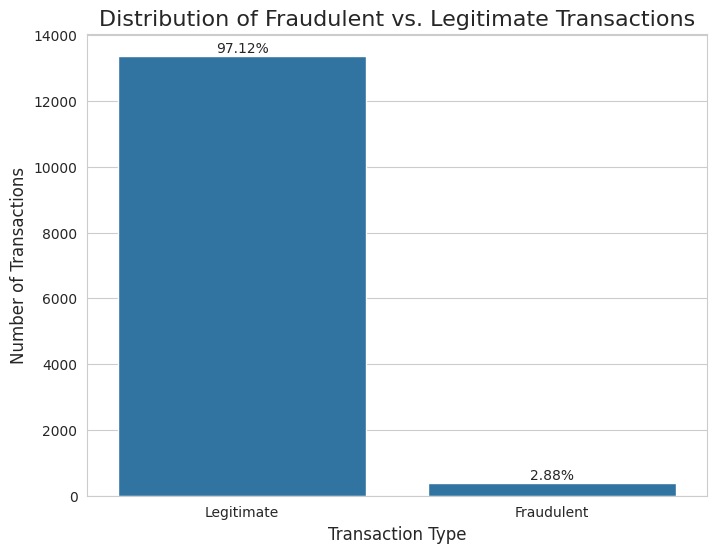

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_fraud', data=final_df)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions', fontsize=16)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])

total = len(final_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()


### Distribution of Key Numerical Features by Fraud Status  

- Visualizes how **transaction amount**, **account age**, and **user risk score** differ between legitimate and fraudulent transactions.  
- Helps identify patterns: e.g., fraud may be associated with **higher amounts**, **newer accounts**, or **higher risk scores**.  
- Log scale is used for transaction amount to handle extreme outliers.


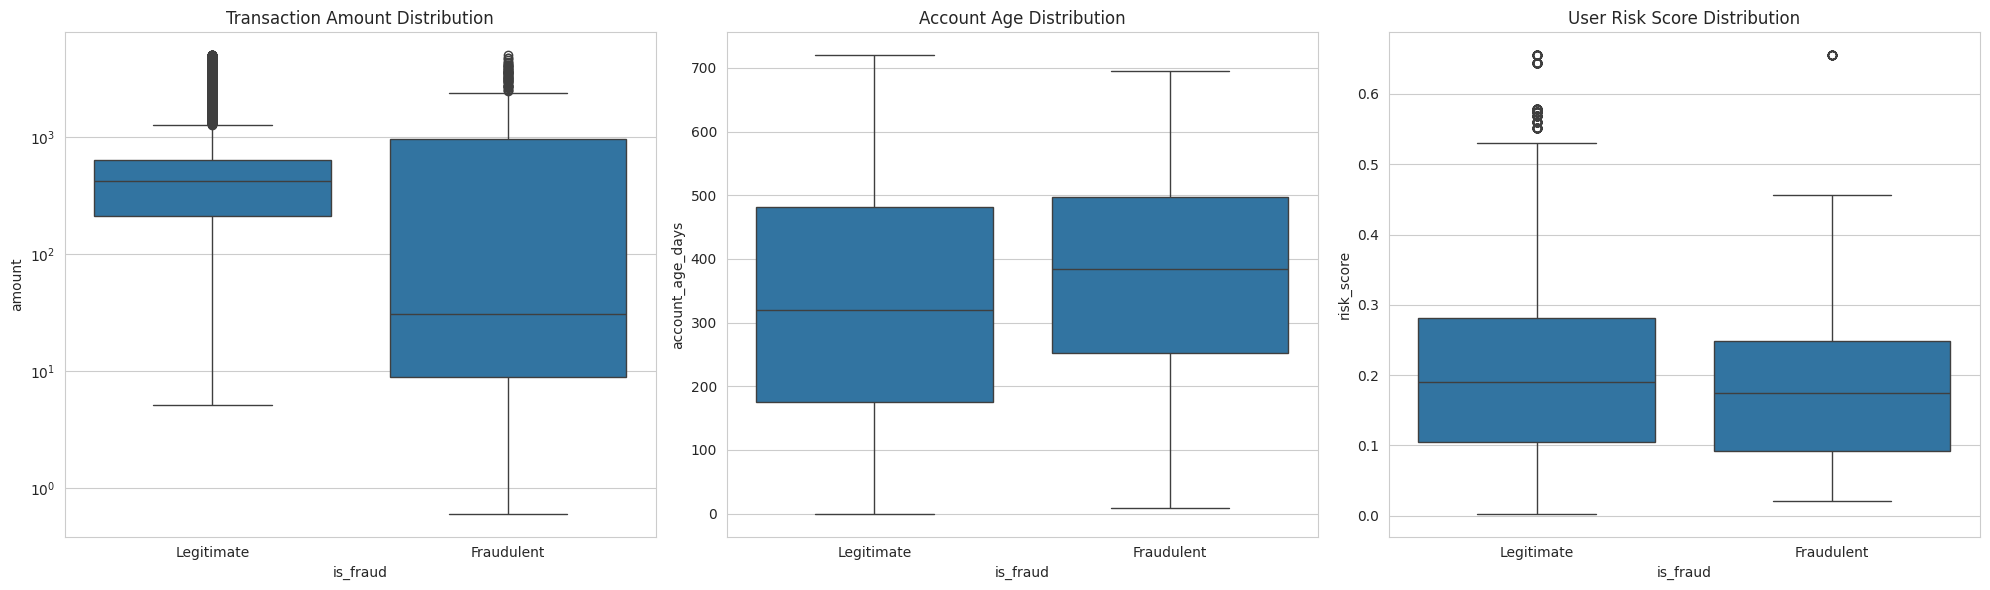

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(x='is_fraud', y='amount', data=final_df, ax=axes[0])
axes[0].set_title('Transaction Amount Distribution')
axes[0].set_yscale('log')  # Use log scale due to outliers
axes[0].set_xticklabels(['Legitimate', 'Fraudulent'])

sns.boxplot(x='is_fraud', y='account_age_days', data=final_df, ax=axes[1])
axes[1].set_title('Account Age Distribution')
axes[1].set_xticklabels(['Legitimate', 'Fraudulent'])

sns.boxplot(x='is_fraud', y='risk_score', data=final_df, ax=axes[2])
axes[2].set_title('User Risk Score Distribution')
axes[2].set_xticklabels(['Legitimate', 'Fraudulent'])

plt.tight_layout()
plt.show()


### Temporal Analysis of Fraud  

- Examines when fraudulent transactions occur in terms of **hour of day** and **day of week**.  
- Helps identify temporal patterns or anomalies, e.g., fraud spikes during unusual hours or weekends.  
- Can inform **feature engineering** for fraud detection models.


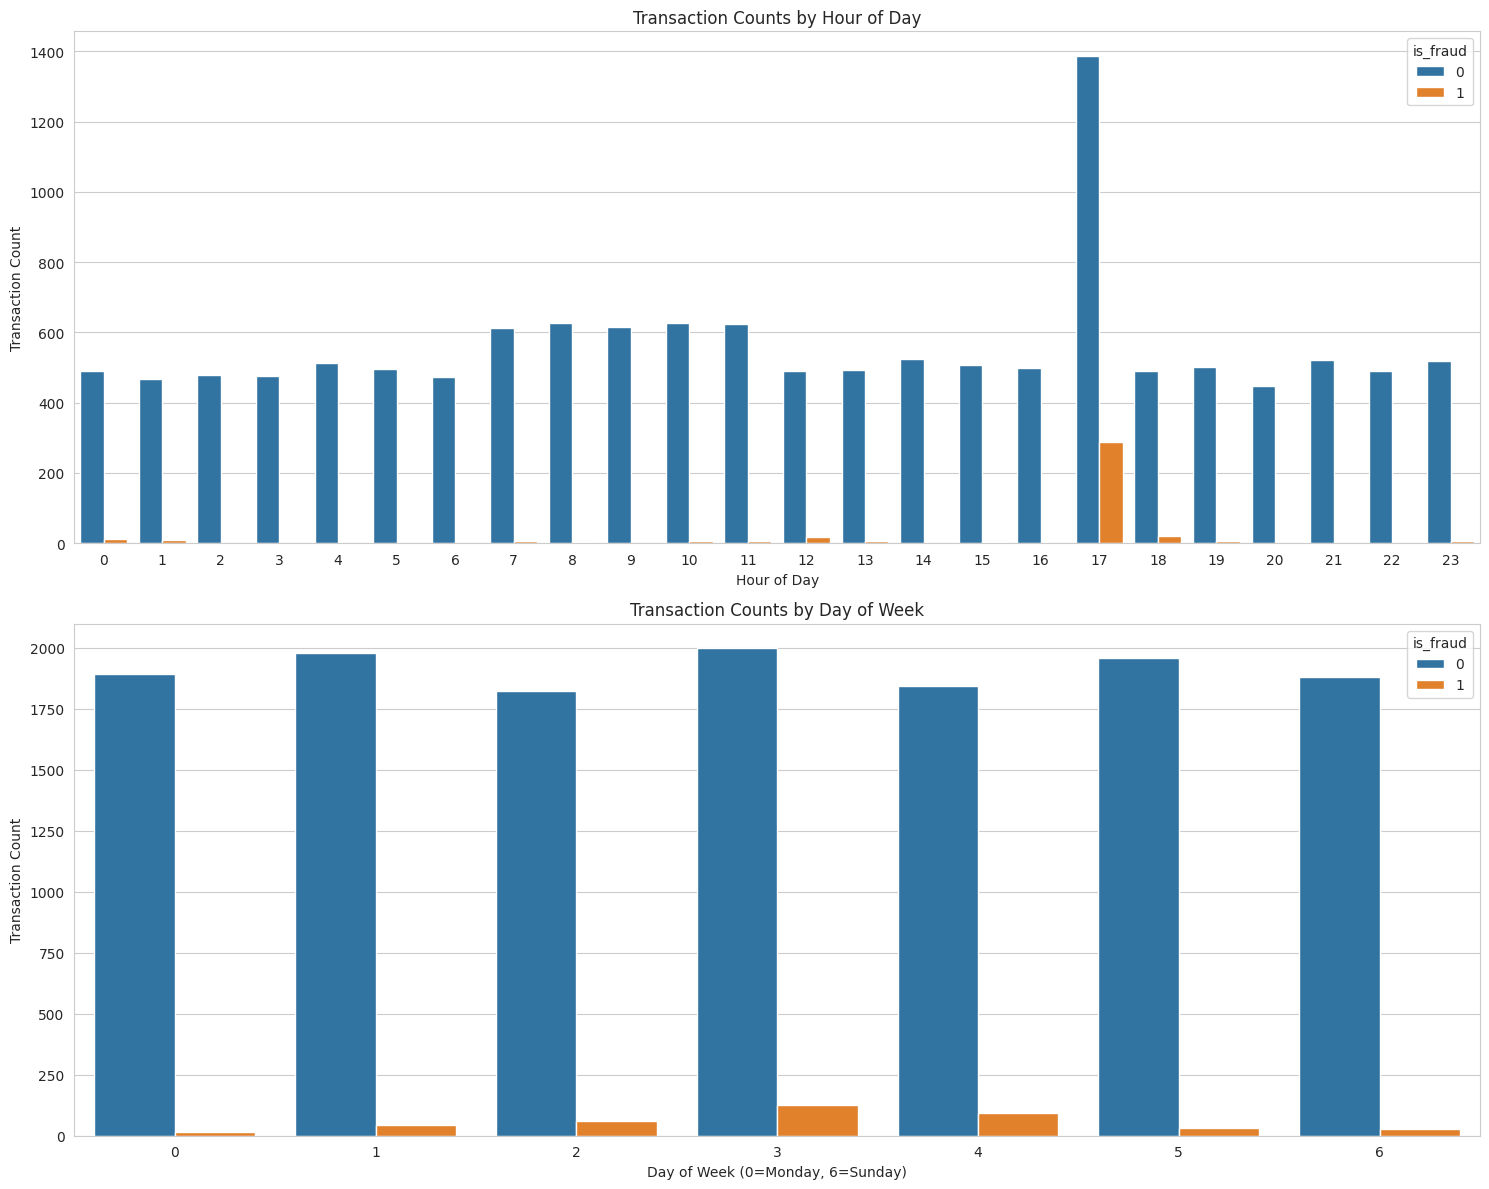

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Fraud by Hour of Day
sns.countplot(x='tx_hour', data=final_df, hue='is_fraud', ax=axes[0])
axes[0].set_title('Transaction Counts by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Transaction Count')

# Fraud by Day of Week
sns.countplot(x='tx_dayofweek', data=final_df, hue='is_fraud', ax=axes[1])
axes[1].set_title('Transaction Counts by Day of Week')
axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
axes[1].set_ylabel('Transaction Count')

plt.tight_layout()
plt.show()


### Fraud Rate by Merchant Category  

- Focuses on the **top 15 merchant categories** for P2M transactions.  
- Calculates the **proportion of fraudulent transactions** (`is_fraud=1`) within each category.  
- Horizontal bar plot shows which merchant categories have higher fraud rates, helping **identify risk-prone categories** for monitoring and feature engineering.


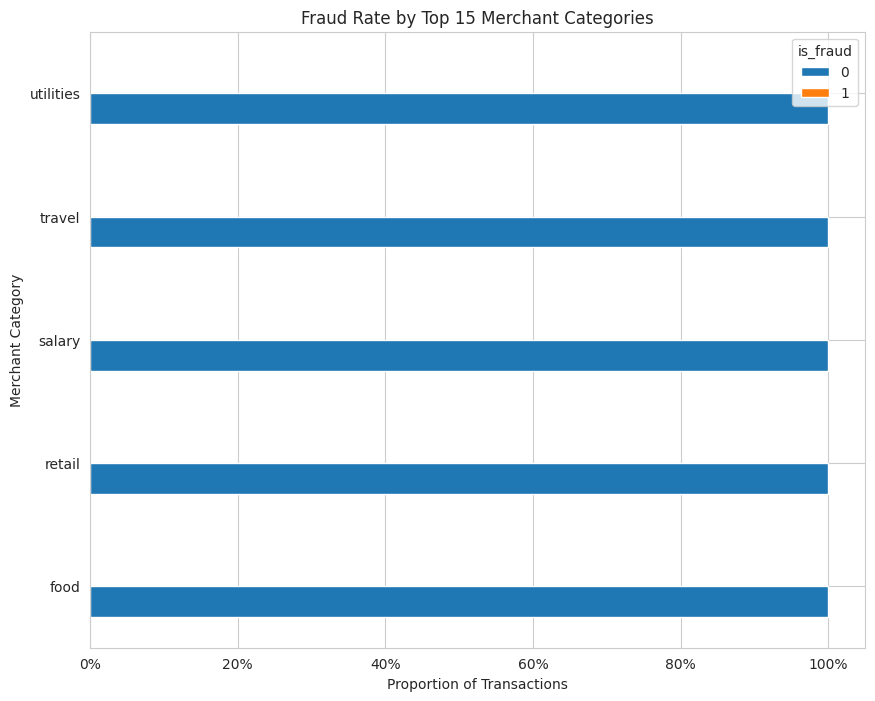

In [ ]:
from matplotlib.ticker import PercentFormatter
top_merchants = (
    final_df[final_df['transaction_type'] == 'P2M']['category']
    .value_counts()
    .nlargest(15)
    .index
)

merchant_fraud = (
    final_df[final_df['category'].isin(top_merchants)]
    .groupby('category')['is_fraud']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

if 1 not in merchant_fraud.columns:
    merchant_fraud[1] = 0

merchant_fraud = merchant_fraud.sort_values(by=1)

merchant_fraud.plot(kind='barh', figsize=(10, 8))
plt.title('Fraud Rate by Top 15 Merchant Categories')
plt.xlabel('Proportion of Transactions')
plt.ylabel('Merchant Category')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.show()


In [ ]:
# Count fraud per category
fraud_per_category = final_df[final_df['transaction_type'] == 'P2M'].groupby('category')['is_fraud'].sum()
print(fraud_per_category)


category
food         0
retail       0
salary       0
travel       0
utilities    0
Name: is_fraud, dtype: int64


### Creating Rolling Window Features  

- Computes **transaction-level statistics** over different time windows (`1h`, `6h`, `24h`, `7d`) for each account.  
- Features include:  
  - `tx_count_*`: number of transactions  
  - `tx_sum_*`: total transaction amount  
  - `tx_mean_*`: average transaction amount  
- Helps capture **behavioral patterns over time**, which are useful for detecting anomalies and fraud.  
- Missing values from rolling calculations are filled with **0** for consistency.


In [ ]:
final_df = final_df.sort_values(by=['account_id', 'timestamp']).set_index('timestamp')

time_windows = ['1h', '6h', '24h', '7d']

def compute_rolling_features(group):
    for window in time_windows:

        group[f'tx_count_{window}'] = group['transaction_id'].rolling(window=window).count()

        group[f'tx_sum_{window}'] = group['amount'].rolling(window=window).sum()

        group[f'tx_mean_{window}'] = group['amount'].rolling(window=window).mean()
    return group

final_df = final_df.groupby('account_id', group_keys=False).apply(compute_rolling_features)

feature_cols = [col for col in final_df.columns if 'tx_count' in col or 'tx_sum' in col or 'tx_mean' in col]
final_df[feature_cols] = final_df[feature_cols].fillna(0)

final_df = final_df.reset_index()

print("Rolling window features created successfully.")


Rolling window features created successfully.


In [ ]:
final_df.head(10)


,timestamp,transaction_id,from_account,merchant_id,amount,channel,device_id,ip_address,is_incoming,is_fraud,...,tx_mean_1h,tx_count_6h,tx_sum_6h,tx_mean_6h,tx_count_24h,tx_sum_24h,tx_mean_24h,tx_count_7d,tx_sum_7d,tx_mean_7d
0,2025-07-24 17:44:11.575962,tx_345,merch_25,NaN,2220.47,bank_credit,unknown_device,0.0.0.0,1,0,...,2220.470000,1.0,2220.47,2220.470000,1.0,2220.47,2220.470000,1.0,2220.47,2220.470000
1,2025-07-24 17:44:11.575962,tx_653,merch_44,NaN,1599.85,bank_credit,unknown_device,0.0.0.0,1,0,...,1910.160000,2.0,3820.32,1910.160000,2.0,3820.32,1910.160000,2.0,3820.32,1910.160000
2,2025-07-24 17:44:11.575962,tx_4389,merch_78,NaN,1437.50,bank_credit,unknown_device,0.0.0.0,1,0,...,1752.606667,3.0,5257.82,1752.606667,3.0,5257.82,1752.606667,3.0,5257.82,1752.606667
3,2025-07-24 17:44:11.575962,tx_6403,merch_78,NaN,4170.17,bank_credit,unknown_device,0.0.0.0,1,0,...,2356.997500,4.0,9427.99,2356.997500,4.0,9427.99,2356.997500,4.0,9427.99,2356.997500
4,2025-07-24 17:44:11.575962,tx_6842,merch_5,NaN,2733.87,bank_credit,unknown_device,0.0.0.0,1,0,...,2432.372000,5.0,12161.86,2432.372000,5.0,12161.86,2432.372000,5.0,12161.86,2432.372000
5,2025-07-24 17:44:11.575962,tx_213,merch_72,NaN,3079.05,bank_credit,unknown_device,0.0.0.0,1,0,...,2540.151667,6.0,15240.91,2540.151667,6.0,15240.91,2540.151667,6.0,15240.91,2540.151667
6,2025-07-24 17:44:11.575962,tx_1715,merch_17,NaN,4865.17,bank_credit,unknown_device,0.0.0.0,1,0,...,2872.297143,7.0,20106.08,2872.297143,7.0,20106.08,2872.297143,7.0,20106.08,2872.297143
7,2025-07-24 17:44:11.575962,tx_12761,merch_78,NaN,2922.61,bank_credit,unknown_device,0.0.0.0,1,0,...,2878.586250,8.0,23028.69,2878.586250,8.0,23028.69,2878.586250,8.0,23028.69,2878.586250
8,2025-07-24 17:44:11.575962,tx_3524,merch_46,NaN,2497.02,bank_credit,unknown_device,0.0.0.0,1,0,...,2836.190000,9.0,25525.71,2836.190000,9.0,25525.71,2836.190000,9.0,25525.71,2836.190000
9,2025-07-24 17:44:11.575962,tx_10361,merch_12,NaN,3897.07,bank_credit,unknown_device,0.0.0.0,1,0,...,2942.278000,10.0,29422.78,2942.278000,10.0,29422.78,2942.278000,10.0,29422.78,2942.278000


### Recency, Deviation, and Indicator Features  

- **Recency:** `time_since_last_tx_seconds` measures how much time has passed since the previous transaction for the same account.  
- **Deviation:** `amount_to_avg_ratio` compares the current transaction amount to the account’s historical average, highlighting unusual spending.  
- **Indicator Features:**  
  - `is_premature_transaction`: flags transactions on accounts with negative age (data irregularity).  
  - `is_night_transaction`: flags transactions occurring between 1 AM and 5 AM, often a higher-risk period.  

These features help capture **behavioral anomalies** that are useful for fraud detection.  


In [ ]:
final_df['time_since_last_tx_seconds'] = final_df.groupby('account_id')['timestamp'].diff().dt.total_seconds().fillna(-1)

final_df['cumulative_avg_amount'] = final_df.groupby('account_id')['amount'].expanding().mean().reset_index(0, drop=True)

final_df['amount_to_avg_ratio'] = final_df['amount'] / (final_df['cumulative_avg_amount'] + 1e-6)
final_df['amount_to_avg_ratio'].fillna(1, inplace=True)
final_df['is_premature_transaction'] = (final_df['account_age_days'] < 0).astype(int)
final_df['is_night_transaction'] = ((final_df['tx_hour'] >= 1) & (final_df['tx_hour'] <= 5)).astype(int)

print("Recency, Deviation, and other indicator features created.")
final_df[['account_id', 'timestamp', 'amount', 'time_since_last_tx_seconds', 'amount_to_avg_ratio']].head(10)

Recency, Deviation, and other indicator features created.


,account_id,timestamp,amount,time_since_last_tx_seconds,amount_to_avg_ratio
0,0,2025-07-24 17:44:11.575962,2220.47,-1.0,1.000000
1,0,2025-07-24 17:44:11.575962,1599.85,0.0,0.837548
2,0,2025-07-24 17:44:11.575962,1437.50,0.0,0.820207
3,0,2025-07-24 17:44:11.575962,4170.17,0.0,1.769272
4,0,2025-07-24 17:44:11.575962,2733.87,0.0,1.123952
5,0,2025-07-24 17:44:11.575962,3079.05,0.0,1.212152
6,0,2025-07-24 17:44:11.575962,4865.17,0.0,1.693825
7,0,2025-07-24 17:44:11.575962,2922.61,0.0,1.015294
8,0,2025-07-24 17:44:11.575962,2497.02,0.0,0.880414
9,0,2025-07-24 17:44:11.575962,3897.07,0.0,1.324508


### Preparing Features and Train-Test Split  

- **Feature Selection:** Exclude identifiers, raw dates, names, and target column (`is_fraud`) to avoid data leakage.  
- **Categorical vs Numerical:** Identify categorical features (e.g., `channel`, `transaction_type`, `region`) and numerical features.  
- **Encoding:** One-hot encode categorical features for model compatibility.  
- **Temporal Split:** Use first 80% of transactions for training and the remaining 20% for testing to **simulate real-world deployment**, ensuring the model sees past data first.  
- **Why:** This prepares a clean, model-ready dataset while preserving temporal order, which is important for fraud detection.  


In [ ]:
features = [col for col in final_df.columns if col not in [
    'transaction_id', 'from_account', 'to_account', 'account_id', 'user_id', 'merchant_id',
    'timestamp', 'created_date', 'signup_date', 'from_account_created_date', 'name_x', 'name_y',
    'is_fraud'
]]

categorical_features = ['channel', 'transaction_type', 'region', 'category', 'account_type']
numerical_features = [f for f in features if f not in categorical_features]
final_df_encoded = pd.get_dummies(final_df, columns=categorical_features, drop_first=True)

encoded_cols = [col for col in final_df_encoded.columns if any(cat_feat in col for cat_feat in categorical_features)]
features_encoded = numerical_features + encoded_cols

X = final_df_encoded[features_encoded]
y = final_df_encoded['is_fraud']

split_index = int(len(final_df_encoded) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Fraud rate in training set: {y_train.mean():.4f}")
print(f"Fraud rate in test set: {y_test.mean():.4f}")

Training set shape: (11015, 50)
Test set shape: (2754, 50)
Fraud rate in training set: 0.0281
Fraud rate in test set: 0.0312


In [ ]:
print(X_train.columns)


Index(['amount', 'device_id', 'ip_address', 'is_incoming', 'account_age_days',
       'tx_hour', 'tx_dayofweek', 'is_new_beneficiary', 'prev_timestamp',
       'last_tx_interval_seconds', 'rolling_tx_count_5', 'rolling_tx_sum_5',
       'rolling_tx_mean_5', 'tx_count_last_1d', 'age', 'risk_score', 'name',
       'tx_count_1h', 'tx_sum_1h', 'tx_mean_1h', 'tx_count_6h', 'tx_sum_6h',
       'tx_mean_6h', 'tx_count_24h', 'tx_sum_24h', 'tx_mean_24h',
       'tx_count_7d', 'tx_sum_7d', 'tx_mean_7d', 'time_since_last_tx_seconds',
       'cumulative_avg_amount', 'amount_to_avg_ratio',
       'is_premature_transaction', 'is_night_transaction', 'channel_ATM',
       'channel_UPI', 'channel_bank_credit', 'channel_bank_transfer',
       'channel_internet', 'channel_mobile_app', 'transaction_type_P2P',
       'region_East', 'region_North', 'region_South', 'region_West',
       'category_p2p_transfer', 'category_retail', 'category_salary',
       'category_travel', 'category_utilities'],
      dtype

### Numeric Feature Selection and Encoding  

- **Select numeric columns:** Identify integer and float features from the training set.  
- **Include encoded categorical columns:** Keep one-hot encoded features for categorical variables (`channel`, `category`, `transaction_type`, `region`).  
- **Encode additional identifiers:** If `device_id` or `ip_address` are included, label encode them to convert strings to numeric values.  

This ensures all features are numeric and ready for models like XGBoost.


In [ ]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_numeric = X_train[numeric_cols.tolist() +
                          [col for col in X_train.columns if 'channel_' in col or 'category_' in col or 'transaction_type_' in col or 'region_' in col]].copy()
from sklearn.preprocessing import LabelEncoder
for col in ['device_id', 'ip_address']:
    if col in X_train_numeric.columns:
        le = LabelEncoder()
        X_train_numeric[col] = le.fit_transform(X_train_numeric[col])


In [ ]:
numeric_cols = X_train_numeric.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric[numeric_cols] = X_train_numeric[numeric_cols].fillna(X_train_numeric[numeric_cols].median())

X_train_numeric = X_train_numeric.fillna(0)


### Handling Class Imbalance with SMOTE-ENN  

- **Problem:** Fraud is a rare event, so the dataset is imbalanced, which can bias the model toward non-fraud.  
- **Solution:** Apply **SMOTE-ENN**, which combines:
  - **SMOTE:** Synthetic Minority Over-sampling Technique to generate synthetic fraud samples.  
  - **ENN:** Edited Nearest Neighbors to clean noisy samples (set to `None` here).  
- **Result:** A balanced training dataset with more representative fraud examples, improving model learning.  
- **Output:** Check original vs. resampled shapes and class distribution to confirm balance.


In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

smote_enn = SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=5), enn=None)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_numeric, y_train)

print("Resampling complete.")
print(f"Original training shape: {X_train_numeric.shape}")
print(f"Resampled training shape: {X_train_resampled.shape}")
print("Resampled class distribution:\n", y_train_resampled.value_counts())


Resampling complete.
Original training shape: (11015, 46)
Resampled training shape: (19414, 46)
Resampled class distribution:
 is_fraud
1    9962
0    9452
Name: count, dtype: int64


In [ ]:
drop_cols = ['device_id', 'ip_address', 'prev_timestamp', 'name', 'timestamp_for_rolling']
existing_drop_cols = [col for col in drop_cols if col in X_train_resampled.columns]

X_train_numeric = X_train_resampled.drop(columns=existing_drop_cols)
X_test_numeric = X_test.drop(columns=existing_drop_cols)


In [ ]:
print(X_train_numeric.columns)


Index(['amount', 'is_incoming', 'account_age_days', 'tx_hour', 'tx_dayofweek',
       'is_new_beneficiary', 'last_tx_interval_seconds', 'rolling_tx_count_5',
       'rolling_tx_sum_5', 'rolling_tx_mean_5', 'tx_count_last_1d', 'age',
       'risk_score', 'tx_count_1h', 'tx_sum_1h', 'tx_mean_1h', 'tx_count_6h',
       'tx_sum_6h', 'tx_mean_6h', 'tx_count_24h', 'tx_sum_24h', 'tx_mean_24h',
       'tx_count_7d', 'tx_sum_7d', 'tx_mean_7d', 'time_since_last_tx_seconds',
       'cumulative_avg_amount', 'amount_to_avg_ratio',
       'is_premature_transaction', 'is_night_transaction', 'channel_ATM',
       'channel_UPI', 'channel_bank_credit', 'channel_bank_transfer',
       'channel_internet', 'channel_mobile_app', 'transaction_type_P2P',
       'region_East', 'region_North', 'region_South', 'region_West',
       'category_p2p_transfer', 'category_retail', 'category_salary',
       'category_travel', 'category_utilities'],
      dtype='object')


In [ ]:
non_numeric_cols = X_test_numeric.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: ['device_id', 'ip_address', 'prev_timestamp', 'name', 'channel_ATM', 'channel_UPI', 'channel_bank_credit', 'channel_bank_transfer', 'channel_internet', 'channel_mobile_app', 'transaction_type_P2P', 'region_East', 'region_North', 'region_South', 'region_West', 'category_p2p_transfer', 'category_retail', 'category_salary', 'category_travel', 'category_utilities']


In [ ]:
X_train_numeric = X_train_numeric.drop(columns=[col for col in non_numeric_cols if col in X_train_numeric.columns])
X_test_numeric = X_test_numeric.drop(columns=[col for col in non_numeric_cols if col in X_test_numeric.columns])


In [ ]:
X_train_numeric = X_train_numeric.apply(pd.to_numeric)
X_test_numeric = X_test_numeric.apply(pd.to_numeric)


In [ ]:
print("X_train_numeric shape:", X_train_numeric.shape)
print("y_train shape:", y_train.shape)


X_train_numeric shape: (19414, 30)
y_train shape: (11015,)


In [ ]:
# Keep only rows in X_train_numeric that exist in y_train index
X_train_numeric = X_train_numeric.loc[y_train.index]


In [ ]:
X_train_numeric.shape[0] == y_train.shape[0]


True

In [ ]:
smote_enn = SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=5), enn=None)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_numeric, y_train)


In [ ]:
print(X_train_numeric.shape, y_train.shape)

(11015, 30) (11015,)


### XGBoost Model Training and Evaluation

**Step 1: Ensure numeric features only**  
- XGBoost requires numeric input.  
- Any non-numeric columns are dropped and remaining columns are converted to numeric.  
- **Why:** Prevent errors during training and ensure all features are compatible with the model.

**Step 2: Handle class imbalance using SMOTE-ENN**  
- **SMOTE:** Generates synthetic fraud samples to balance the dataset.  
- **ENN (Edited Nearest Neighbors):** Cleans noisy samples (here set to `None`).  
- **Why:** Fraud is rare, so balancing helps the model learn patterns for minority class effectively.

**Step 3: Compute `scale_pos_weight`**  
- Calculated as ratio of negative to positive samples in the resampled training set.  
- **Why:** Helps XGBoost handle class imbalance internally during training, improving recall for fraud cases.

**Step 4: Initialize and train XGBoost**  
- Parameters include learning rate, max depth, subsample, colsample, gamma, and `scale_pos_weight`.  
- **Why:** These hyperparameters control model complexity, overfitting, and sensitivity to imbalanced classes.

**Step 5: Make predictions on test set**  
- Predict both class labels (`y_pred_xgb`) and probabilities (`y_pred_proba_xgb`).  
- **Why:** Probabilities are needed for precision-recall curve evaluation and threshold tuning.

**Step 6: Evaluate the model**  
- Use `classification_report` to check precision, recall, and F1-score for fraud vs. legitimate.  
- Calculate **AUC-PR (Precision-Recall curve)** to evaluate performance on imbalanced data.  
- **Why:** Standard accuracy can be misleading due to class imbalance; PR-AUC better reflects fraud detection effectiveness.


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, precision_recall_curve, auc
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

non_numeric_cols = X_test_numeric.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

X_train_numeric = X_train_numeric.drop(columns=[col for col in non_numeric_cols if col in X_train_numeric.columns])
X_test_numeric = X_test_numeric.drop(columns=[col for col in non_numeric_cols if col in X_test_numeric.columns])

X_train_numeric = X_train_numeric.apply(pd.to_numeric)
X_test_numeric = X_test_numeric.apply(pd.to_numeric)

smote_enn = SMOTEENN(random_state=42, smote=SMOTE(k_neighbors=5), enn=None)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_numeric, y_train)

print("Resampling complete.")
print(f"Original training shape: {X_train_numeric.shape}")
print(f"Resampled training shape: {X_train_resampled.shape}")
print("Resampled class distribution:\n", y_train_resampled.value_counts())

neg_count = (y_train_resampled == 0).sum()
pos_count = (y_train_resampled == 1).sum()
scale_pos_weight_val = neg_count / pos_count

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    scale_pos_weight=scale_pos_weight_val,  # float
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost baseline model...")
xgb_classifier.fit(X_train_resampled, y_train_resampled)
print("Training complete.")

y_pred_xgb = xgb_classifier.predict(X_test_numeric)
y_pred_proba_xgb = xgb_classifier.predict_proba(X_test_numeric)[:, 1]

print("\n--- XGBoost Baseline Model Evaluation ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Legitimate', 'Fraudulent']))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
auc_pr_xgb = auc(recall, precision)
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr_xgb:.4f}")


Non-numeric columns: []
Resampling complete.
Original training shape: (11015, 30)
Resampled training shape: (14942, 30)
Resampled class distribution:
 is_fraud
1    8542
0    6400
Name: count, dtype: int64
Training XGBoost baseline model...
Training complete.

--- XGBoost Baseline Model Evaluation ---
              precision    recall  f1-score   support

  Legitimate       0.98      0.95      0.96      2668
  Fraudulent       0.19      0.36      0.25        86

    accuracy                           0.93      2754
   macro avg       0.59      0.66      0.61      2754
weighted avg       0.95      0.93      0.94      2754

Area Under Precision-Recall Curve (AUC-PR): 0.1770


### Heterogeneous Graph Creation

**Purpose:** Model multiple entities and relationships for fraud detection using a graph.

- **Nodes:** `account`, `merchant`, `device_id`, `ip_address`  
  Each entity mapped to a unique integer ID and initialized with 16-dim random embeddings.

- **Edges (relations):**  
  - P2P transactions: `account -> account`  
  - P2M transactions: `account -> merchant`  
  - Account-device links: `account -> device_id`  
  - Account-IP links: `account -> ip_address`  

**Why:**  
- Numeric node IDs are required for GNNs.  
- Edges capture interactions for message passing.  
- Node embeddings are learnable features for model training.

**Result:**  
- `graph_data` contains nodes, embeddings, and edges for all entity types, ready for GNN-based fraud detection.


In [ ]:
from collections import defaultdict

graph_data = HeteroData()
node_types = ['account', 'merchant', 'device_id', 'ip_address']
entity_maps = {}
for node_type in node_types:
    if node_type == 'account':
        unique_entities = pd.concat([final_df['from_account'], final_df[final_df['transaction_type']=='P2P']['to_account']]).unique()
    elif node_type == 'merchant':
        unique_entities = final_df['merchant_id'].dropna().unique()
    else:
        unique_entities = final_df[node_type].unique()
    entity_maps[node_type] = {entity: i for i, entity in enumerate(unique_entities)}

embedding_dim = 16
for node_type, mapping in entity_maps.items():
    num_nodes = len(mapping)
    graph_data[node_type].x = torch.randn(num_nodes, embedding_dim)

p2p_df = final_df[final_df['transaction_type'] == 'P2P']
src = [entity_maps['account'][i] for i in p2p_df['from_account']]
dst = [entity_maps['account'][i] for i in p2p_df['to_account']]
graph_data['account', 'sends_to', 'account'].edge_index = torch.tensor([src, dst], dtype=torch.long)

p2m_df = final_df[final_df['transaction_type'] == 'P2M']
src = [entity_maps['account'][i] for i in p2m_df['from_account']]
dst = [entity_maps['merchant'][i] for i in p2m_df['merchant_id']]
graph_data['account', 'pays', 'merchant'].edge_index = torch.tensor([src, dst], dtype=torch.long)

acc_dev_map = final_df[['from_account', 'device_id']].drop_duplicates()
src = [entity_maps['account'][i] for i in acc_dev_map['from_account']]
dst = [entity_maps['device_id'][i] for i in acc_dev_map['device_id']]
graph_data['account', 'used_device', 'device_id'].edge_index = torch.tensor([src, dst], dtype=torch.long)

acc_ip_map = final_df[['from_account', 'ip_address']].drop_duplicates()
src = [entity_maps['account'][i] for i in acc_ip_map['from_account']]
dst = [entity_maps['ip_address'][i] for i in acc_ip_map['ip_address']]
graph_data['account', 'used_ip', 'ip_address'].edge_index = torch.tensor([src, dst], dtype=torch.long)

print("Heterogeneous graph created successfully.")
print(graph_data)

Heterogeneous graph created successfully.
HeteroData(
  account={ x=[588, 16] },
  merchant={ x=[80, 16] },
  device_id={ x=[669, 16] },
  ip_address={ x=[1103, 16] },
  (account, sends_to, account)={ edge_index=[2, 8309] },
  (account, pays, merchant)={ edge_index=[2, 5460] },
  (account, used_device, device_id)={ edge_index=[2, 723] },
  (account, used_ip, ip_address)={ edge_index=[2, 1157] }
)


### Heterogeneous Graph Neural Network (HeteroGNN)

**Purpose:** Learn node embeddings for fraud detection from multi-entity interactions.

- **Architecture:**  
  - 2-layer `HeteroConv` with `SAGEConv` for all relations:  
    - `account -> account` (P2P)  
    - `account -> merchant` (P2M)  
    - `account -> device_id`  
    - `account -> ip_address`  
    - Reverse edges included for message passing  
  - Aggregation: `sum`  
  - Node features passed through ReLU  
  - Linear layer maps `account` embeddings to output classes

- **Graph Prep:** Convert `graph_data` to undirected (`ToUndirected`) for bidirectional propagation.

- **Instantiation:**  
  ```python
  gnn_model = HeteroGNN(hidden_channels=64, out_channels=2, num_layers=2)
  print(gnn_model)


In [ ]:
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.transforms import ToUndirected

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('account', 'sends_to', 'account'): SAGEConv((-1, -1), hidden_channels),
                ('account', 'pays', 'merchant'): SAGEConv((-1, -1), hidden_channels),
                ('account', 'used_device', 'device_id'): SAGEConv((-1, -1), hidden_channels),
                ('account', 'used_ip', 'ip_address'): SAGEConv((-1, -1), hidden_channels),
                ('merchant', 'rev_pays', 'account'): SAGEConv((-1, -1), hidden_channels),
                ('device_id', 'rev_used_device', 'account'): SAGEConv((-1, -1), hidden_channels),
                ('ip_address', 'rev_used_ip', 'account'): SAGEConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        return self.lin(x_dict['account'])
graph_data = ToUndirected()(graph_data)
gnn_model = HeteroGNN(hidden_channels=64, out_channels=2, num_layers=2)
print(gnn_model)


HeteroGNN(
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=7)
  )
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### GNN Training on Account Nodes

**Purpose:** Map the tabular train/test split to graph nodes and train the HeteroGNN for fraud prediction.

**Steps:**

1. **Create Masks:**
   - `train_mask` & `test_mask` based on transaction time.
   - Map `from_account` IDs to node indices in `graph_data`.

2. **Node Labels:**
   - An account is labeled fraudulent if **any transaction** is fraud.
   - Stored in `graph_data['account'].y`.

3. **Training Setup:**
   - Move model & data to `device` (GPU/CPU).
   - Use Adam optimizer (`lr=0.01`) and weight decay.
   - Compute class weights to handle imbalance.
   - Loss: `CrossEntropyLoss` with class weights.

4. **Training Loop:**
   - 100 epochs, update node embeddings with backprop.
   - Every 10 epochs, print training accuracy on account nodes.

5. **Testing:**
   - Predict node labels and compute accuracy on masked nodes (`train_mask` or `test_mask`).

**Why:**  
This approach ensures the GNN learns from **temporal splits**, handles **class imbalance**, and propagates information across accounts, merchants, devices, and IPs to detect fraudulent accounts effectively.


In [ ]:
train_accounts = set(final_df.iloc[:split_index]['from_account'])
test_accounts = set(final_df.iloc[split_index:]['from_account'])

train_mask = torch.zeros(graph_data['account'].num_nodes, dtype=torch.bool)
test_mask = torch.zeros(graph_data['account'].num_nodes, dtype=torch.bool)

account_map_inv = {v: k for k, v in entity_maps['account'].items()}

for i in range(graph_data['account'].num_nodes):
    acc_id = account_map_inv[i]
    if acc_id in train_accounts:
        train_mask[i] = True
    if acc_id in test_accounts:
        test_mask[i] = True

graph_data['account'].train_mask = train_mask
graph_data['account'].test_mask = test_mask
account_labels = final_df.groupby('from_account')['is_fraud'].max()
labels = torch.zeros(graph_data['account'].num_nodes, dtype=torch.long)
for acc_id, is_fraud in account_labels.items():
    if acc_id in entity_maps['account']:
        idx = entity_maps['account'][acc_id]
        labels[idx] = is_fraud
graph_data['account'].y = labels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gnn_model = gnn_model.to(device)
graph_data = graph_data.to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=5e-4)

class_counts = torch.bincount(graph_data['account'].y[graph_data['account'].train_mask])
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

def train():
    gnn_model.train()
    optimizer.zero_grad()
    out = gnn_model(graph_data.x_dict, graph_data.edge_index_dict)
    loss = loss_fn(out[graph_data['account'].train_mask], graph_data['account'].y[graph_data['account'].train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(mask):
    gnn_model.eval()
    pred = gnn_model(graph_data.x_dict, graph_data.edge_index_dict).argmax(dim=-1)
    correct = pred[mask] == graph_data['account'].y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred

print("Training GNN model...")
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        train_acc, _ = test(graph_data['account'].train_mask)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}')

print("Training complete.")

Training GNN model...
Epoch: 010, Loss: 0.4942, Train Acc: 0.9044
Epoch: 020, Loss: 0.1433, Train Acc: 0.9711
Epoch: 030, Loss: 0.0074, Train Acc: 1.0000
Epoch: 040, Loss: 0.0010, Train Acc: 1.0000
Epoch: 050, Loss: 0.0004, Train Acc: 1.0000
Epoch: 060, Loss: 0.0004, Train Acc: 1.0000
Epoch: 070, Loss: 0.0005, Train Acc: 1.0000
Epoch: 080, Loss: 0.0006, Train Acc: 1.0000
Epoch: 090, Loss: 0.0008, Train Acc: 1.0000
Epoch: 100, Loss: 0.0009, Train Acc: 1.0000
Training complete.


### GNN Model Evaluation

**Purpose:** Evaluate the trained HeteroGNN on the test set and compare its performance with tabular models.

**Steps:**

1. **Node Predictions:**
   - Compute softmax probabilities and predicted labels for all account nodes.
   - `y_pred_proba_gnn_all`: probability of fraud.
   - `y_pred_gnn_all`: predicted class (0=Legitimate, 1=Fraudulent).

2. **Map Node Predictions to Transactions:**
   - Each transaction inherits the prediction of its `from_account`.
   - Only valid accounts in the graph are considered.

3. **Test Set Evaluation:**
   - Slice predictions corresponding to the temporal test split.
   - Compute **classification report**: precision, recall, F1-score.
   - Compute **AUC-PR** (Area Under Precision-Recall Curve) for fraud detection.

**Why:**  
Mapping node-level predictions back to transactions ensures **fair comparison** with tabular baselines and evaluates how well the GNN captures account-level fraud patterns across the network.


In [ ]:
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(graph_data.x_dict, graph_data.edge_index_dict)
    y_pred_proba_gnn_all = F.softmax(out, dim=1)[:, 1].cpu().numpy()
    y_pred_gnn_all = out.argmax(dim=-1).cpu().numpy()

transaction_to_account_idx = [entity_maps['account'].get(acc, -1) for acc in final_df_encoded['from_account']]
valid_indices = [i for i, idx in enumerate(transaction_to_account_idx) if idx!= -1]

y_pred_proba_gnn = np.zeros(len(final_df_encoded))
y_pred_gnn = np.zeros(len(final_df_encoded))

y_pred_proba_gnn[valid_indices] = y_pred_proba_gnn_all[list(map(lambda x: transaction_to_account_idx[x], valid_indices))]
y_pred_gnn[valid_indices] = y_pred_gnn_all[list(map(lambda x: transaction_to_account_idx[x], valid_indices))]

y_pred_gnn_test = y_pred_gnn[split_index:]
y_pred_proba_gnn_test = y_pred_proba_gnn[split_index:]

print("\n--- GNN Model Evaluation ---")
print(classification_report(y_test, y_pred_gnn_test, target_names=['Legitimate', 'Fraudulent']))

precision_gnn, recall_gnn, _ = precision_recall_curve(y_test, y_pred_proba_gnn_test)
auc_pr_gnn = auc(recall_gnn, precision_gnn)
print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr_gnn:.4f}")


--- GNN Model Evaluation ---
              precision    recall  f1-score   support

  Legitimate       0.97      0.90      0.93      2668
  Fraudulent       0.00      0.00      0.00        86

    accuracy                           0.87      2754
   macro avg       0.48      0.45      0.46      2754
weighted avg       0.94      0.87      0.90      2754

Area Under Precision-Recall Curve (AUC-PR): 0.0343


### SHAP Explainability for XGBoost

**Purpose:** Understand which features contribute most to the XGBoost fraud predictions.

**Steps:**

1. **Prepare Numeric Data:**
   - Drop non-numeric columns from `X_test` since SHAP requires numeric input.

2. **Generate SHAP Values:**
   - Use `shap.TreeExplainer` on the trained XGBoost model.
   - `shap_values_xgb` captures the contribution of each feature to the predictions.

3. **Visualizations:**
   - **Global Importance (Bar Plot):** Ranks features by average absolute contribution.
   - **Beeswarm Plot:** Shows feature impact for individual transactions, highlighting both magnitude and direction.

**Why:**  
SHAP allows **interpretable insights** into which factors drive fraud predictions, helping validate the model and guide feature engineering.


Non-numeric columns to drop: ['device_id', 'ip_address', 'prev_timestamp', 'name', 'channel_ATM', 'channel_UPI', 'channel_bank_credit', 'channel_bank_transfer', 'channel_internet', 'channel_mobile_app', 'transaction_type_P2P', 'region_East', 'region_North', 'region_South', 'region_West', 'category_p2p_transfer', 'category_retail', 'category_salary', 'category_travel', 'category_utilities']
Generating SHAP explanations for the XGBoost baseline model...
Displaying global feature importance (Bar plot)...


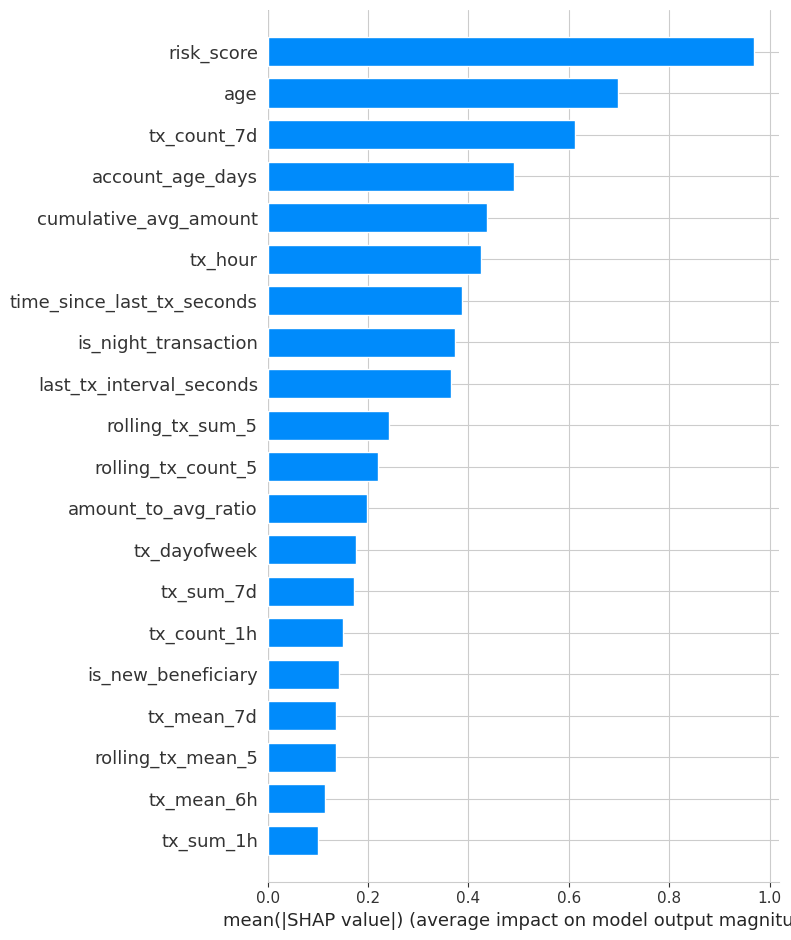

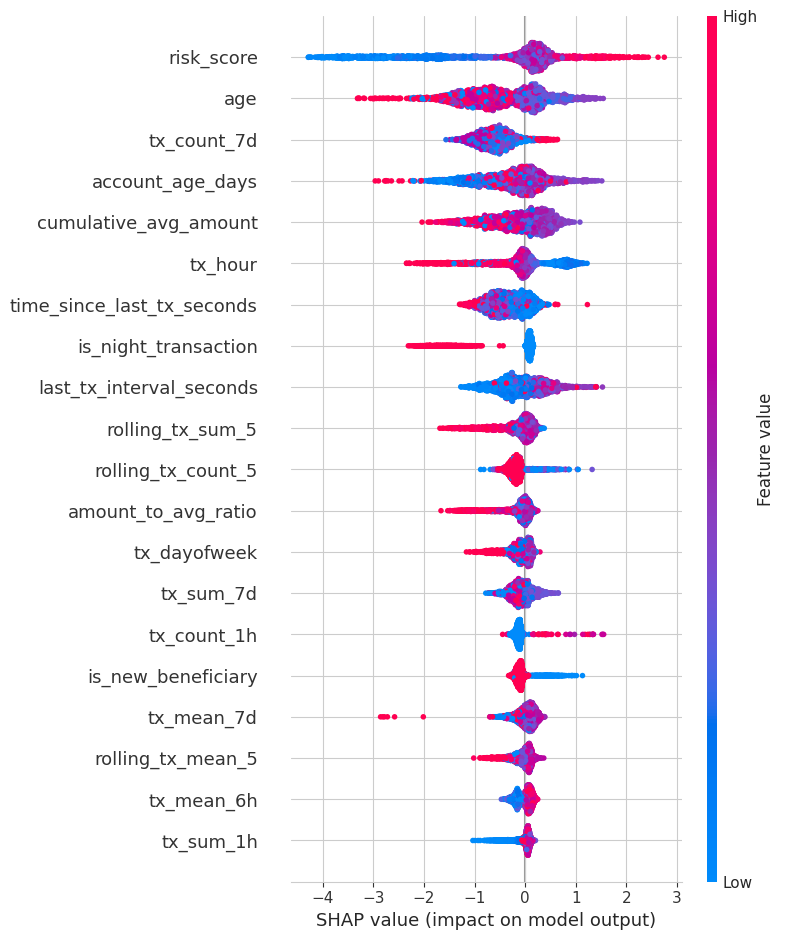

In [ ]:
non_numeric_cols = X_test.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
print("Non-numeric columns to drop:", non_numeric_cols)
X_test_numeric_for_shap = X_test.drop(columns=non_numeric_cols)
import shap
print("Generating SHAP explanations for the XGBoost baseline model...")
explainer_xgb = shap.TreeExplainer(xgb_classifier)
shap_values_xgb = explainer_xgb(X_test_numeric_for_shap)
print("Displaying global feature importance (Bar plot)...")
shap.summary_plot(shap_values_xgb, X_test_numeric_for_shap, plot_type="bar", max_display=20)
shap.summary_plot(shap_values_xgb, X_test_numeric_for_shap, max_display=20)


# **Unsupervised Fraud Detection Using VAE**

Fraudulent transactions are **rare and imbalanced**, making supervised detection challenging.  
We use a **Variational Autoencoder (VAE)** to model **normal transactions** and detect anomalies via **reconstruction errors**.

---

## **1. Feature Engineering**
- Selected features: `amount`, `risk_score`, `account_age_days`, `tx_hour/day`, rolling transaction counts/sums (`tx_count_1h`, `tx_sum_1h`, etc.)
- Temporal train-test split to prevent data leakage
- Standardization (`StandardScaler`) for stable training

**Reason:** Rolling features capture recent activity; scaling ensures VAE convergence.

---

## **2. VAE Data Preparation**
- Train only on normal transactions (`is_fraud == 0`)  
- Convert data to PyTorch tensors and use batches

**Reason:** Fraudulent transactions become **out-of-distribution**, detectable via reconstruction error.

---

## **3. VAE Architecture**
- **Encoder:** Maps input to latent space (`mu`, `logvar`)  
- **Reparameterization:** Sample latent vector `z` for backpropagation  
- **Decoder:** Reconstructs transaction features  
- **Loss:** `Reconstruction Loss + KL Divergence`  

**Reason:** Learns compact representation of normal transactions; anomalies yield high reconstruction errors.

---

## **4. Training**
- Optimizer: Adam (lr=1e-3)  
- Short training (10 epochs for demo)  
- Batch-wise reconstruction + KL loss

**Reason:** Latent space efficiently models normal transaction patterns.

---

## **5. Anomaly Scoring**
- Reconstruct test transactions using VAE  
- **Score:** Mean squared reconstruction error  
- High error → likely fraud

---

## **6. Outcome**
- `unsupervised_anomaly_scores` stores anomaly scores for all test transactions  
- Can be **combined with supervised models** (XGBoost/GNN) for **hybrid fraud detection**


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
try:
    transactions_df = pd.read_csv("ueba_transactions_featured.csv")
    accounts_df = pd.read_csv("ueba_accounts.csv")
    users_df = pd.read_csv("ueba_users.csv")
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure all required CSV files are uploaded.")
    exit()

def engineer_features(transactions, accounts, users):
    """
    Consolidates all feature engineering with a robust fix for the rolling window calculation.
    """
    print("Starting advanced feature engineering...")
    cols_to_drop = [
        'account_id', 'from_account_created_date', 'account_age_days', 'tx_hour',
        'tx_dayofweek', 'is_new_beneficiary', 'prev_timestamp', 'last_tx_interval_seconds',
        'rolling_tx_count_5', 'rolling_tx_sum_5', 'rolling_tx_mean_5', 'tx_count_last_1d'
    ]
    df = transactions.drop(columns=cols_to_drop, errors='ignore')

    df = df.merge(accounts[['account_id', 'user_id', 'created_date']], left_on='from_account', right_on='account_id', how='left')
    df = df.merge(users[['user_id', 'risk_score']], on='user_id', how='left')
    df.rename(columns={'created_date': 'account_created_date'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['account_created_date'] = pd.to_datetime(df['account_created_date'])
    df.sort_values(by='timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['account_age_days'] = (df['timestamp'] - df['account_created_date']).dt.days.fillna(0).clip(lower=0)
    df['tx_hour'] = df['timestamp'].dt.hour
    df['tx_dayofweek'] = df['timestamp'].dt.dayofweek

    time_windows = ['1h', '6h', '24h', '7d']

    for window in time_windows:
        df[f'tx_count_{window}'] = 0
        df[f'tx_sum_{window}'] = 0

    processed_dfs = []
    for account_id, group in tqdm(df.groupby('from_account'), desc="Calculating Rolling Features"):
        group = group.sort_values('timestamp').set_index('timestamp')
        for window in time_windows:
            rolling_agg = group['amount'].rolling(window=window)
            group[f'tx_count_{window}'] = rolling_agg.count()
            group[f'tx_sum_{window}'] = rolling_agg.sum()
        processed_dfs.append(group.reset_index())

    df = pd.concat(processed_dfs).sort_index()
    df.fillna(0, inplace=True)

    print("Feature engineering complete.")
    return df

featured_df = engineer_features(transactions_df, accounts_df, users_df)
features_for_models = [
    'amount', 'risk_score', 'account_age_days', 'tx_hour', 'tx_dayofweek',
    'tx_count_1h', 'tx_sum_1h', 'tx_count_6h', 'tx_sum_6h',
    'tx_count_24h', 'tx_sum_24h', 'tx_count_7d', 'tx_sum_7d'
]
target = 'is_fraud'

X = featured_df[features_for_models]
y = featured_df[target]

split_index = int(len(featured_df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n--- Training VAE for Anomaly Detection on {DEVICE} ---")

X_train_normal = X_train_scaled[y_train == 0]
X_train_normal_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
vae_train_loader = DataLoader(TensorDataset(X_train_normal_tensor), batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU())
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 32), nn.ReLU(), nn.Linear(32, input_dim))
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

vae_model = VAE(input_dim=X_train_normal.shape[1]).to(DEVICE)
optimizer = Adam(vae_model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for (data,) in vae_train_loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar = vae_model(data)
        loss = F.mse_loss(recon, data, reduction='sum') - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'VAE Epoch: {epoch+1}, Average Loss: {total_loss / len(vae_train_loader.dataset):.4f}')

vae_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(DEVICE)
    reconstructions, _, _ = vae_model(X_test_tensor)
    unsupervised_anomaly_scores = ((X_test_tensor - reconstructions) ** 2).mean(axis=1).cpu().numpy()

print(f"\nGenerated {len(unsupervised_anomaly_scores)} unsupervised anomaly scores.")

All datasets loaded successfully.
Starting advanced feature engineering...


Calculating Rolling Features: 100%|██████████| 555/555 [00:06<00:00, 83.73it/s]


Feature engineering complete.

--- Training VAE for Anomaly Detection on cpu ---
VAE Epoch: 1, Average Loss: 11.7708
VAE Epoch: 2, Average Loss: 7.9676
VAE Epoch: 3, Average Loss: 7.1480
VAE Epoch: 4, Average Loss: 6.8726
VAE Epoch: 5, Average Loss: 6.6946
VAE Epoch: 6, Average Loss: 6.5088
VAE Epoch: 7, Average Loss: 6.3400
VAE Epoch: 8, Average Loss: 6.1901
VAE Epoch: 9, Average Loss: 6.0535
VAE Epoch: 10, Average Loss: 5.9265

Generated 2754 unsupervised anomaly scores.


# **Relational Fraud Detection Using GNN Embeddings**

To capture relational patterns between accounts, devices, and IP addresses, we use a **Graph Neural Network (GNN)**. The goal is to generate **node embeddings** for accounts that reflect their transactional and relational behavior.

---

## **1. Map IDs to Integer Indices**
- All categorical IDs (`from_account`, `to_account`, `device_id`, `ip_address`) are mapped to **unique integers**.  
- Reasoning: PyTorch Geometric requires **integer node indices** for graph construction.

---

## **2. Construct Heterogeneous Graph (`HeteroData`)**
- **Nodes:**  
  - `account`, `device`, `ip`  
  - Node features are initialized as **identity matrices** (one-hot embeddings for simplicity).  
- **Edges:**  
  - `account -> account` (`sends_to`)  
  - `account -> device` (`uses_device`)  
  - `account -> ip` (`uses_ip`)  
- **Bidirectional Edges:**  
  - `ToUndirected` ensures **reverse relationships** are also captured.  

**Reason:** Heterogeneous graphs allow modeling **multi-entity relationships**, crucial for fraud detection.

---

## **3. GNN Model (HeteroConv + SAGEConv)**
- **HeteroConv:** Handles multiple edge types in a single layer.  
- **SAGEConv:** Aggregates information from neighbors for each node.  
- Forward pass returns **node embeddings** for each entity type.

**Reason:** Each account embedding captures **both its attributes and relational context**, improving downstream fraud detection.

---

## **4. Generate Node Embeddings**
- Forward pass through the GNN produces `node_embeddings` for all accounts, devices, and IPs.  
- Extract **account embeddings** specifically.

```python
account_embeddings = node_embeddings['account'].cpu().numpy()


In [ ]:
import torch
import torch.nn as nn
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.transforms import ToUndirected

print("\n--- Generating GNN Embeddings ---")

all_accounts = pd.concat([transactions_df['from_account'], transactions_df['to_account']]).unique()
account_map = {acc: i for i, acc in enumerate(all_accounts)}
device_map = {dev: i for i, dev in enumerate(transactions_df['device_id'].unique())}
ip_map = {ip: i for i, ip in enumerate(transactions_df['ip_address'].unique())}

data = HeteroData()

data['account'].x = torch.eye(len(account_map))
data['device'].x = torch.eye(len(device_map))
data['ip'].x = torch.eye(len(ip_map))

df_mapped = transactions_df.copy()
df_mapped['from_idx'] = df_mapped['from_account'].map(account_map)
df_mapped['to_idx'] = df_mapped['to_account'].map(account_map)
df_mapped['device_idx'] = df_mapped['device_id'].map(device_map)
df_mapped['ip_idx'] = df_mapped['ip_address'].map(ip_map)
df_mapped.dropna(subset=['from_idx', 'to_idx', 'device_idx', 'ip_idx'], inplace=True)
for col in ['from_idx', 'to_idx', 'device_idx', 'ip_idx']:
    df_mapped[col] = df_mapped[col].astype(int)

data['account', 'sends_to', 'account'].edge_index = torch.tensor([df_mapped['from_idx'].values, df_mapped['to_idx'].values], dtype=torch.long)
data['account', 'uses_device', 'device'].edge_index = torch.tensor([df_mapped['from_idx'].values, df_mapped['device_idx'].values], dtype=torch.long)
data['account', 'uses_ip', 'ip'].edge_index = torch.tensor([df_mapped['from_idx'].values, df_mapped['ip_idx'].values], dtype=torch.long)

data = ToUndirected()(data)

class GNNEncoder(nn.Module):
    def __init__(self, hidden_channels=32):
        super().__init__()
        self.conv = HeteroConv({
            meta: SAGEConv((-1, -1), hidden_channels) for meta in data.edge_types
        }, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        return self.conv(x_dict, edge_index_dict)

gnn_model = GNNEncoder().to(DEVICE)
data = data.to(DEVICE)
with torch.no_grad():
    node_embeddings = gnn_model(data.x_dict, data.edge_index_dict)

account_embeddings = node_embeddings['account'].cpu().numpy()

gnn_emb_df = pd.DataFrame(account_embeddings, index=account_map.keys()).add_prefix('gnn_emb_')
featured_df = featured_df.merge(gnn_emb_df, left_on='from_account', right_index=True, how='left').fillna(0)

print(f"Generated GNN embeddings with shape: {account_embeddings.shape}")


--- Generating GNN Embeddings ---
Generated GNN embeddings with shape: (658, 32)


# Behavior Transformer for Sequential Fraud Detection

Fraudulent transactions often follow patterns over time rather than appearing in isolation. To capture these temporal behaviors, we train a **Behavior Transformer** on sequences of GNN embeddings representing account relationships.

---

## 1. Sequential Data Preparation
- For each account, sequences of the last transactions (up to `MAX_SEQ_LENGTH`) are constructed using GNN embeddings.
- Short sequences are **padded with zeros** to ensure uniform length.
- Labels correspond to whether the **current transaction is fraudulent**.
- **Reason:** This captures **temporal dependencies** and transaction history patterns, which are crucial for detecting subtle fraudulent behavior.

---

## 2. Temporal Train-Test Split
- Sequences are split **chronologically**, with 80% for training and 20% for testing.
- **Reason:** Preserves transaction timelines to avoid **data leakage** and simulate real-world detection where future transactions are unknown.

---

## 3. Behavior Transformer Architecture
- **Transformer Encoder:** Learns dependencies across transaction sequences.
- **Classifier:** Uses the final hidden state to predict fraud probability.
- **Reason:** Transformers can model **long-range relationships** in transaction sequences, identifying patterns not visible in individual transactions.

---

## 4. Model Training
- **Loss Function:** Binary Cross-Entropy, minimizing the error between predicted and true fraud labels.
- **Optimizer:** Adam, to efficiently update model parameters.
- Training on sequences allows the model to learn **temporal and behavioral patterns** that distinguish normal from fraudulent activity.
- **Reason:** Optimizing sequence-level predictions ensures the model captures both **recent trends** and **long-term patterns**.

---

## 5. Generating Supervised Fraud Probabilities
- After training, the model predicts the **fraud probability** for each transaction in the test set.
- **Outcome:** Each transaction receives a score reflecting its likelihood of being fraudulent based on **historical behavior and relational context**.

---

## 6. Important Notes
- Combines **GNN embeddings** (relational context) with **Transformer sequences** (temporal behavior).
- Detects **subtle fraud patterns** that may not be obvious in isolation.
- These **supervised probabilities** can be integrated with **unsupervised anomaly scores** (e.g., from VAE) for a **hybrid fraud detection system**.
- Padding sequences and temporal splitting ensure **robust, realistic modeling** of real-world transaction data.


In [ ]:
import math
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
print("\n--- Training Behavior Transformer on GNN Sequences ---")

embedding_cols = [col for col in featured_df.columns if 'gnn_emb_' in col]
MAX_SEQ_LENGTH = 15
sequences, labels, original_indices = [], [], []
for _, group in tqdm(featured_df.groupby('from_account'), desc="Creating Sequences"):
    embeddings = group[embedding_cols].values
    fraud_labels = group['is_fraud'].values
    indices = group.index.values

    for i in range(1, len(embeddings)):
        seq = embeddings[max(0, i - MAX_SEQ_LENGTH):i]
        padded_seq = np.zeros((MAX_SEQ_LENGTH, embeddings.shape[1]))
        padded_seq[-len(seq):] = seq
        sequences.append(padded_seq)
        labels.append(fraud_labels[i])
        original_indices.append(indices[i])

X_seq = np.array(sequences, dtype=np.float32)
y_seq = np.array(labels, dtype=np.float32)

sequence_df = pd.DataFrame({'original_index': original_indices, 'y_true': y_seq})

seq_split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:seq_split_idx], X_seq[seq_split_idx:]
y_train_seq, y_test_seq = y_seq[:seq_split_idx], y_seq[seq_split_idx:]
test_sequence_df = sequence_df.iloc[seq_split_idx:].copy()

class BehaviorTransformer(nn.Module):
    def __init__(self, d_model, nhead=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(nn.Linear(d_model, 1), nn.Sigmoid())
    def forward(self, src):
        output = self.transformer_encoder(src)
        return self.classifier(output[:, -1, :])

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train_seq).unsqueeze(1)), batch_size=64, shuffle=True)
transformer_model = BehaviorTransformer(d_model=X_train_seq.shape[2]).to(DEVICE)
optimizer = Adam(transformer_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(5):
    for seq_batch, label_batch in train_loader:
        seq_batch, label_batch = seq_batch.to(DEVICE), label_batch.to(DEVICE)
        optimizer.zero_grad()
        predictions = transformer_model(seq_batch)
        loss = criterion(predictions, label_batch)
        loss.backward()
        optimizer.step()
transformer_model.eval()
with torch.no_grad():
    test_tensor = torch.from_numpy(X_test_seq).to(DEVICE)
    supervised_fraud_probs = transformer_model(test_tensor).cpu().numpy().flatten()

test_sequence_df['supervised_prob'] = supervised_fraud_probs

print(f"\nGenerated {len(supervised_fraud_probs)} supervised fraud probabilities.")


--- Training Behavior Transformer on GNN Sequences ---


Creating Sequences: 100%|██████████| 555/555 [00:00<00:00, 905.45it/s]



Generated 2643 supervised fraud probabilities.


# Contextual Bandit for Adaptive Fraud Decisioning

To make **adaptive transaction decisions**, we use a **Contextual Bandit** approach that dynamically selects actions (Approve, Challenge, Block) based on transaction context, supervised predictions, and unsupervised anomaly scores.

---

## 1. Preparing the Context
- **Context features** include:
  - Transaction amount
  - Account risk score
  - Supervised fraud probability (from Behavior Transformer)
  - Unsupervised anomaly score (from VAE)
- **Reason:** Combining multiple signals allows the bandit to make informed decisions that balance risk and user experience.

---

## 2. Defining the Reward Function
- Rewards reflect **business value and risk**:
  - Approving a legitimate transaction: +1 (good UX)
  - Approving a fraudulent transaction: -100 (high financial loss)
  - Challenging legitimate transaction: -1 (user friction)
  - Challenging fraud: +50 (fraud caught)
  - Blocking legitimate transaction: -10 (very bad UX)
  - Blocking fraud: +80 (successful prevention)
- **Reason:** The reward function encodes **trade-offs between fraud prevention and customer experience**, guiding the bandit to optimal decisions.

---

## 3. LinUCB Bandit Algorithm
- **LinUCB** models the expected reward for each action as a linear function of the context features.
- **Alpha parameter** controls exploration vs. exploitation.
- **Workflow:**
  1. Predict the best action for each transaction using current model parameters.
  2. Compute the reward based on actual fraud label and chosen action.
  3. Update the model using observed context, action, and reward.
- **Reason:** LinUCB allows **adaptive decision-making**, improving over time as more transactions are observed.

---

## 4. Simulation and Evaluation
- Each transaction in the test set is processed sequentially.
- The bandit chooses an action and receives a reward based on the true label.
- **Total cumulative reward** measures overall effectiveness of the strategy.
- **Action distribution** shows how often the bandit chose Approve, Challenge, or Block.
- **Reason:** Sequential simulation mimics real-world deployment, ensuring the policy adapts to evolving transaction patterns.

---

## 5. Key Takeaways
- Combines **supervised (Transformer)** and **unsupervised (VAE)** signals into a single adaptive decision-making framework.
- Optimizes for **both fraud prevention and user experience**.
- Can be deployed in real-time to dynamically select actions for each transaction based on its context.
- Bandit approach allows **continuous learning**, improving decisions as more transaction data becomes available.


In [ ]:
from contextualbandits.online import LinUCB

print("\n--- Simulating Contextual Bandit ---")

final_test_df = featured_df.loc[test_sequence_df['original_index']].copy()
final_test_df['supervised_prob'] = test_sequence_df['supervised_prob'].values
final_test_df['unsupervised_score'] = unsupervised_anomaly_scores[np.searchsorted(featured_df.index, final_test_df.index)]

context_features = ['amount', 'risk_score', 'supervised_prob', 'unsupervised_score']
context_matrix = final_test_df[context_features].values
true_labels = final_test_df['is_fraud'].values

def calculate_reward(action, is_fraud):
    if action == 0 and not is_fraud: return 1
    if action == 0 and is_fraud: return -100
    if action == 1 and not is_fraud: return -1
    if action == 1 and is_fraud: return 50
    if action == 2 and not is_fraud: return -10
    if action == 2 and is_fraud: return 80
    return 0

bandit_policy = LinUCB(n_actions=3, alpha=0.1, context_dim=len(context_features))
total_reward = 0
actions_taken = []

for i in tqdm(range(len(context_matrix)), desc="Bandit Simulation"):
    context = context_matrix[i]
    action = bandit_policy.predict(context.reshape(1, -1))
    reward = calculate_reward(action, true_labels[i])
    bandit_policy.fit(context.reshape(1, -1), np.array([action]), np.array([reward]))
    total_reward += reward
    actions_taken.append(action)

print(f"\nTotal cumulative reward from bandit strategy: {total_reward:.2f}")
action_map = {0: 'Approve', 1: 'Challenge', 2: 'Block'}
print("Final Action distribution:\n", pd.Series(actions_taken).map(action_map).value_counts(normalize=True))

# Final Consolidated Fraud Inference Pipeline

This function encapsulates the **end-to-end hybrid fraud detection pipeline** for a single incoming transaction. It integrates **feature engineering, GNN embeddings, sequential modeling, VAE anomaly detection, and contextual bandit decisioning** into a unified inference workflow.

---

## 1. Real-Time Feature Engineering
- Extracts relevant features from the incoming transaction:
  - Transaction amount
  - Account age
  - Transaction hour and day of the week
  - Other engineered features (e.g., new beneficiary flag)
- **Reasoning:** Features are standardized and prepared in the same format as training data to ensure consistency with learned models.  

---

## 2. Graph Update & GNN Embeddings
- Retrieves the **GNN embedding** for the account associated with the transaction.
- In production, the graph would be updated in real-time and a forward pass performed on the relevant subgraph.
- **Reasoning:** GNN embeddings capture **relational patterns** between accounts, devices, and IPs, providing rich contextual signals for fraud detection.

---

## 3. Sequence Creation & Transformer Inference
- Builds a **sequence of recent GNN embeddings** for the account.
- Appends the new transaction’s embedding to the sequence.
- Passes the sequence through the **Behavior Transformer** to predict a **supervised fraud probability**.
- **Reasoning:** Sequential modeling captures **temporal transaction patterns**, allowing detection of suspicious behavior over time.

---

## 4. VAE Anomaly Scoring
- Uses the **trained VAE** to reconstruct the feature vector of the transaction.
- Computes the **unsupervised anomaly score** as the mean squared reconstruction error.
- **Reasoning:** VAE highlights transactions that **deviate from normal behavior**, complementing the supervised signal.

---

## 5. Context Vector Assembly
- Combines the following into a single **context vector** for decision-making:
  - Transaction amount
  - Account age
  - Supervised fraud probability (Transformer)
  - Unsupervised anomaly score (VAE)
- **Reasoning:** Combining multiple signals allows the decision policy to make informed, adaptive choices.

---

## 6. Adaptive Decisioning with Contextual Bandit
- Feeds the context vector to a **LinUCB contextual bandit**.
- Bandit chooses one of three actions: **Approve, Challenge (2FA), Block**.
- **Reasoning:** Contextual bandit balances **fraud prevention and user experience**, dynamically adapting to observed patterns and rewards.

---

## 7. Output
The function returns a dictionary containing:
- `decision`: Final adaptive action (`APPROVE`, `CHALLENGE_2FA`, `BLOCK`)
- `supervised_fraud_prob`: Probability predicted by the Transformer
- `unsupervised_anomaly_score`: VAE reconstruction-based anomaly score
- `context_vector`: Combined features used by the bandit

---

## Key Takeaways
- Integrates **supervised**, **unsupervised**, and **relational learning** signals.
- Produces **adaptive, real-time decisions** on incoming transactions.
- Can serve as a **production-ready inference module** for hybrid fraud detection systems.


In [ ]:
def predict_fraud(transaction_data: dict, feature_store: dict, models: dict, graph_data: dict):
    """
    Encapsulates the entire end-to-end inference pipeline for a single transaction.

    Args:
        transaction_data (dict): Raw data for the new transaction.
        feature_store (dict): A lookup for historical data to engineer features.
        models (dict): Contains the pre-trained gnn, transformer, vae, and bandit models.
        graph_data (dict): Contains the current graph structure and mappings.
    """

    engineered_features = {
        'amount': transaction_data['amount'],
        'account_age_days': 100,
        'transaction_hour': datetime.now().hour,
        'transaction_day_of_week': datetime.now().weekday(),
        'is_new_beneficiary': 1,

    }

    feature_vector = np.array([engineered_features.get(f, 0) for f in features])
    scaled_feature_vector = models['scaler'].transform(feature_vector.reshape(1, -1))

    tx_idx_to_use = full_df_for_graph['timestamp'].sub(pd.to_datetime(transaction_data['timestamp'])).abs().idxmin()
    gnn_embedding = full_df_for_graph.loc[tx_idx_to_use, embedding_cols].values

    recent_sequence = X_test_seq[-1]

    new_sequence = np.vstack([recent_sequence[1:], gnn_embedding])

    transformer_model = models['transformer']
    transformer_model.eval()
    with torch.no_grad():
        seq_tensor = torch.from_numpy(new_sequence).unsqueeze(0).float().to(DEVICE)
        supervised_prob = transformer_model(seq_tensor).item()


    vae_model = models['vae']
    vae_model.eval()
    with torch.no_grad():
        feature_tensor = torch.from_numpy(scaled_feature_vector).float().to(DEVICE)
        recon, _, _ = vae_model(feature_tensor)
        unsupervised_score = ((feature_tensor - recon) ** 2).mean().item()

    context_vector = np.array([
        transaction_data['amount'],
        engineered_features['account_age_days'],
        supervised_prob,
        unsupervised_score
    ])

    bandit_policy = models['bandit']
    action = bandit_policy.predict(context_vector.reshape(1, -1))

    action_map = {0: 'APPROVE', 1: 'CHALLENGE_2FA', 2: 'BLOCK'}

    return {
        'decision': action_map[action],
        'supervised_fraud_prob': supervised_prob,
        'unsupervised_anomaly_score': unsupervised_score,
        'context_vector': context_vector.tolist()
    }

all_models = {
    'scaler': scaler,
    'gnn': gnn_model,
    'transformer': transformer_model,
    'vae': vae_model,
    'bandit': bandit_policy
}

new_tx = {
    'transaction_id': 'tx_new_123',
    'from_account': 'acc_45',
    'to_account': 'mule_acc_1_2',
    'amount': 3450.78,
    'timestamp': datetime.now().isoformat(),
    'device_id': 'dev_fraud_1',
    'ip_address': '123.45.67.89'
}

final_decision = predict_fraud(new_tx, feature_store={}, models=all_models, graph_data={})
print(f"\n--- Final Inference Pipeline Output ---")
print(final_decision)